In [4]:
# Load dataset
from nilmtk import DataSet
ukdale = DataSet(r"C:\Users\Raymond Tie\Desktop\NILM\datasets\ukdale.h5")

# Show all buildings
print("Buildings:", ukdale.buildings.keys())


Buildings: odict_keys([1, 2, 3, 4, 5])


hierarchical database in UKDALE
```text
/building1/
    electricity/
        mains/1
        appliance/1
        appliance/2
    metadata.yaml
/building2/...
```


In [5]:
# Pick one building
building1 = dataset.buildings[1]
elec1 = building1.elec

In [6]:
print("Available appliances (sorted by name):")

# Extract (type, instance) from each appliance
appliance_list = [(app.metadata['type'], app.metadata['instance']) for app in elec1.appliances]

# Sort by appliance name, then by instance number
appliance_list = sorted(appliance_list, key=lambda x: (x[0].lower(), x[1]))

# Print list
for appl_type, instance in appliance_list:
    print(f"- {appl_type} (instance {instance})")

# Print total count
print(f"\nTotal number of appliances: {len(appliance_list)}")


Available appliances (sorted by name):
- active subwoofer (instance 1)
- audio amplifier (instance 1)
- audio system (instance 1)
- audio system (instance 2)
- baby monitor (instance 1)
- baby monitor (instance 2)
- boiler (instance 1)
- breadmaker (instance 1)
- broadband router (instance 1)
- charger (instance 1)
- clothes iron (instance 1)
- coffee maker (instance 1)
- computer (instance 1)
- computer monitor (instance 1)
- desktop computer (instance 1)
- dish washer (instance 1)
- drill (instance 1)
- ethernet switch (instance 1)
- external hard disk (instance 1)
- fan (instance 1)
- fan (instance 2)
- food processor (instance 1)
- food processor (instance 2)
- fridge freezer (instance 1)
- hair dryer (instance 1)
- hair straighteners (instance 1)
- HTPC (instance 1)
- immersion heater (instance 1)
- kettle (instance 1)
- kitchen aid (instance 1)
- laptop computer (instance 1)
- laptop computer (instance 2)
- laptop computer (instance 3)
- light (instance 1)
- light (instance 2)
- 

In [7]:
# Show aggregate mains
mains = elec1.mains()
print(mains)

ElecMeter(instance=54, building=1, dataset='UK-DALE', site_meter, appliances=[Appliance(type='immersion heater', instance=1), Appliance(type='water pump', instance=1), Appliance(type='security alarm', instance=1), Appliance(type='fan', instance=2), Appliance(type='drill', instance=1), Appliance(type='laptop computer', instance=2)])


In [8]:
# Show fridge (if available)
fridge = elec1['fridge']
print(fridge)

ElecMeter(instance=12, building=1, dataset='UK-DALE', appliances=[Appliance(type='fridge freezer', instance=1)])


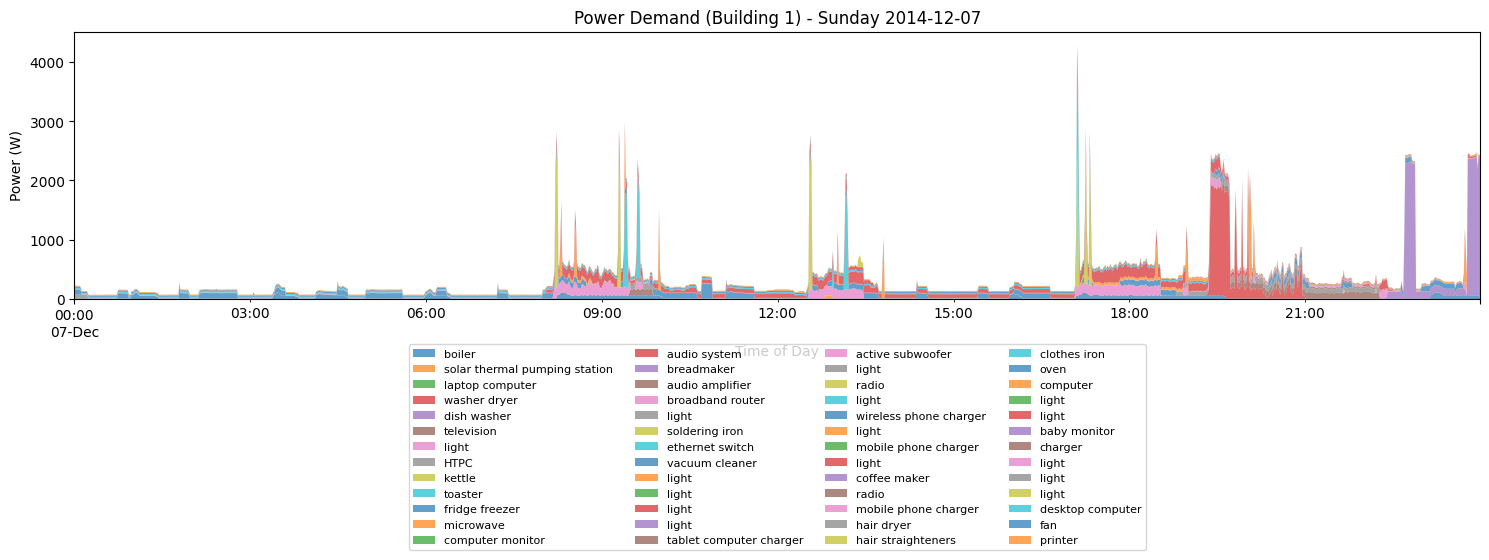

In [ ]:
import matplotlib.pyplot as plt
from nilmtk import DataSet
import pandas as pd

# Load dataset
dataset = DataSet(r"C:\Users\Raymond Tie\Desktop\NILM\datasets\ukdale.h5")
building = dataset.buildings[1]
elec = building.elec

# Select the day
day = "2014-12-07"
start = pd.Timestamp(day + " 00:00:00", tz="UTC")
end = pd.Timestamp(day + " 23:59:59", tz="UTC")

# Prepare dataframe for each appliance
appliance_dfs = []
labels = []
for appliance in elec.submeters().meters:
    label = appliance.appliances[0].type['type'] if appliance.appliances else "unknown"
    
    # Load data (full, then slice by time)
    df = next(appliance.load(sample_period=60))
    df = df[start:end]   # time slice using Pandas
    
    if ('power', 'active') in df.columns:
        y = df[('power', 'active')]
    else:
        y = df.iloc[:, 0]
        
    appliance_dfs.append(y)
    labels.append(label)

# Combine into single dataframe
df_all = pd.concat(appliance_dfs, axis=1)
df_all.columns = labels
df_all = df_all.fillna(0)

# Plot stacked area chart
plt.figure(figsize=(15,6))
df_all.plot.area(ax=plt.gca(), alpha=0.7, linewidth=0)

plt.title("Power Demand (Building 1) - Sunday 2014-12-07")
plt.ylabel("Power (W)")
plt.xlabel("Time of Day")

# Legend below plot
plt.legend(
    loc="upper center", 
    bbox_to_anchor=(0.5, -0.15),  # position below
    ncol=4,                       # number of columns for compact layout
    fontsize=8
)

plt.tight_layout()
plt.show()


C:\Users\Raymond Tie\AppData\Local\Temp\ipykernel_24464\3606855937.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_major["Others"] = df_others


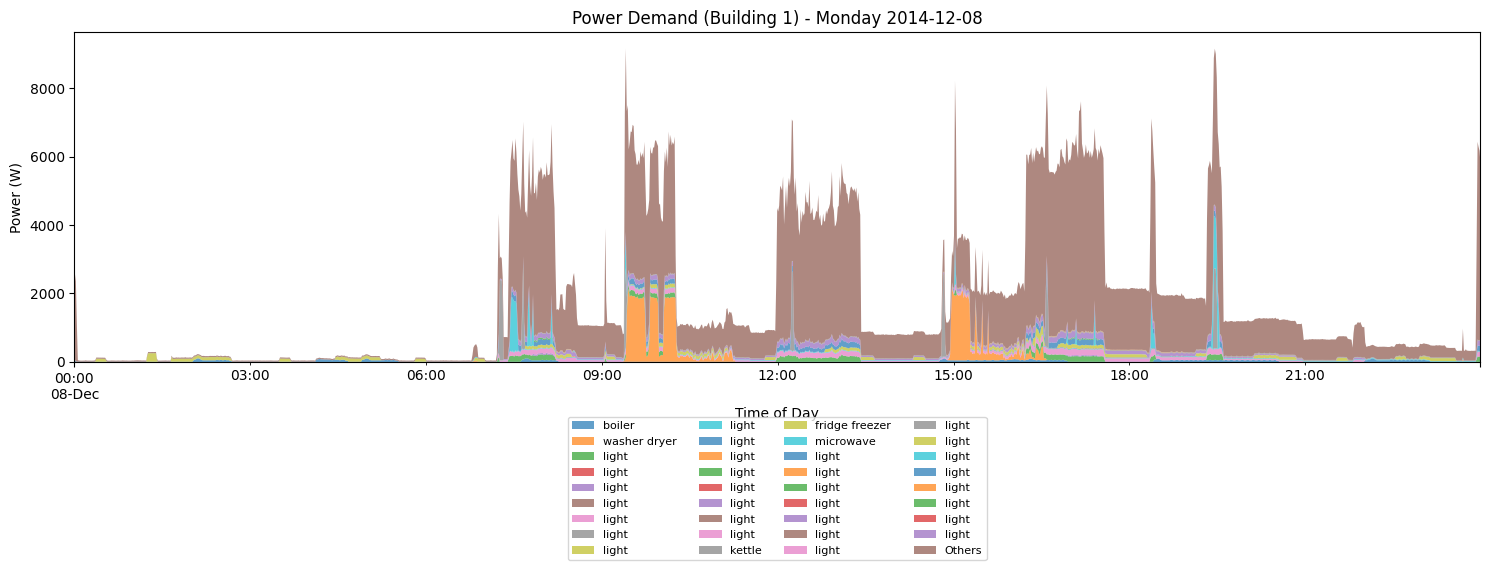

In [ ]:
import matplotlib.pyplot as plt
from nilmtk import DataSet
import pandas as pd

# Load dataset
dataset = DataSet(r"C:\Users\Raymond Tie\Desktop\NILM\datasets\ukdale.h5")
building = dataset.buildings[1]
elec = building.elec

# Select the day
day = "2014-12-08"
start = pd.Timestamp(day + " 00:00:00", tz="UTC")
end = pd.Timestamp(day + " 23:59:59", tz="UTC")

# Prepare dataframe for each appliance
appliance_dfs = []
labels = []
for appliance in elec.submeters().meters:
    label = appliance.appliances[0].type['type'] if appliance.appliances else "unknown"
    
    # Load data
    df = next(appliance.load(sample_period=60))
    df = df[start:end]   # slice by time
    
    if ('power', 'active') in df.columns:
        y = df[('power', 'active')]
    else:
        y = df.iloc[:, 0]
        
    appliance_dfs.append(y)
    labels.append(label)

# Combine into single dataframe
df_all = pd.concat(appliance_dfs, axis=1)
df_all.columns = labels
df_all = df_all.fillna(0)

# --- Group small contributors into "Others" ---
energy_sum = df_all.sum()
threshold = 0.05 * energy_sum.sum()   # 5% of total energy
major_appliances = energy_sum[energy_sum >= threshold].index
minor_appliances = energy_sum[energy_sum < threshold].index

df_major = df_all[major_appliances]
df_others = df_all[minor_appliances].sum(axis=1)
df_major["Others"] = df_others

# Plot stacked area chart
plt.figure(figsize=(15,6))
df_major.plot.area(ax=plt.gca(), alpha=0.7, linewidth=0)

plt.title("Power Demand (Building 1) - Monday 2014-12-08")
plt.ylabel("Power (W)")
plt.xlabel("Time of Day")

# Legend moved below plot
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),  # push below the x-axis
    ncol=4,                       # arrange in columns
    fontsize=8
)

plt.tight_layout()
plt.show()


c:\Users\Raymond Tie\Desktop\NILM\.venv\Lib\site-packages\nilmtk\utils.py:509: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")
C:\Users\Raymond Tie\AppData\Local\Temp\ipykernel_24464\1735364344.py:58: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(mains_active.index, mains_active, color="black", label="Mains (active power)", linewidth=1.5)


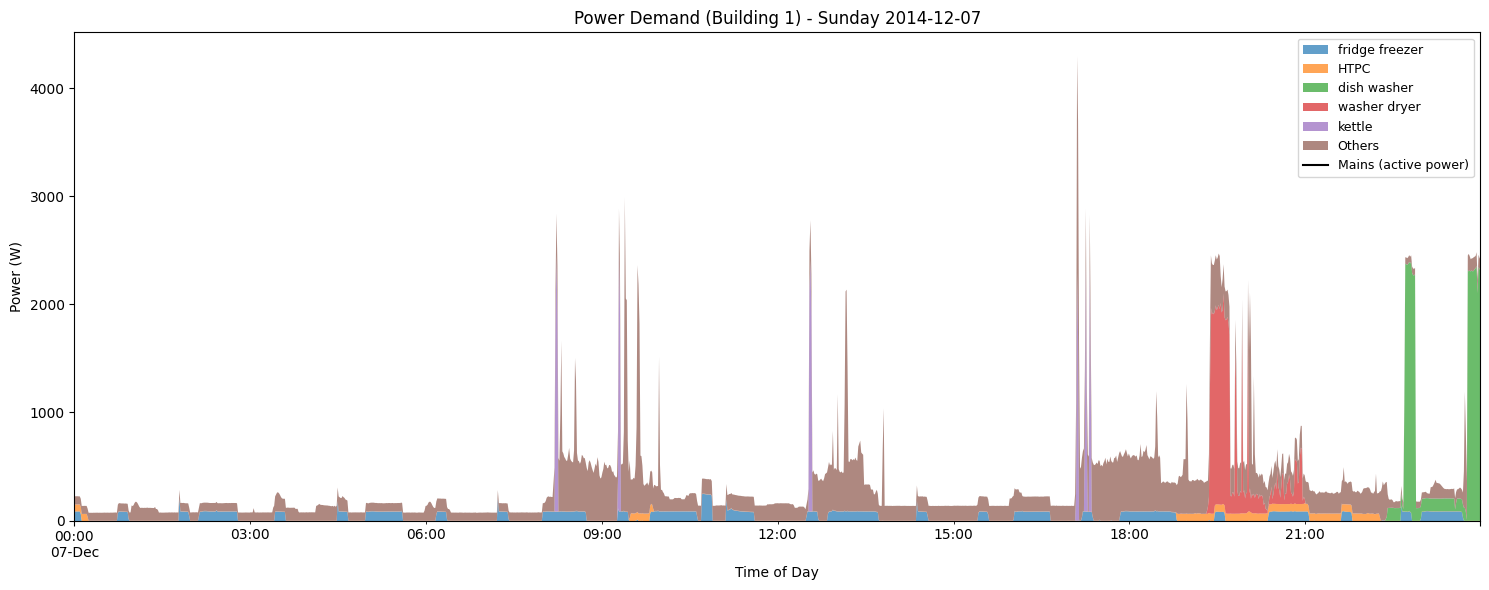

In [ ]:
import matplotlib.pyplot as plt
from nilmtk import DataSet
import pandas as pd

# Load dataset
dataset = DataSet(r"C:\Users\Raymond Tie\Desktop\NILM\datasets\ukdale.h5")
building = dataset.buildings[1]
elec = building.elec

# Select the day
day = "2014-12-07"
start = pd.Timestamp(day + " 00:00:00", tz="UTC")
end = pd.Timestamp(day + " 23:59:59", tz="UTC")

# Target appliance categories to group
target_appliances = ["fridge freezer", "HTPC", "dish washer", "washer dryer", "kettle"]

# Collect appliance data
appliance_dfs = {}
for appliance in elec.submeters().meters:
    label = appliance.appliances[0].type['type'] if appliance.appliances else "unknown"
    
    # Load data
    df = next(appliance.load(sample_period=60))
    df = df[start:end]
    
    if ('power', 'active') in df.columns:
        y = df[('power', 'active')]
    else:
        y = df.iloc[:, 0]
        
    # Group by appliance type (ignore instance)
    if label in appliance_dfs:
        appliance_dfs[label] = appliance_dfs[label].add(y, fill_value=0)
    else:
        appliance_dfs[label] = y

# Convert to DataFrame
df_all = pd.DataFrame(appliance_dfs).fillna(0)

# Keep target appliances, group the rest into "Others"
df_selected = df_all.reindex(columns=target_appliances, fill_value=0)
df_selected["Others"] = df_all.drop(columns=target_appliances, errors="ignore").sum(axis=1)

# Add mains (active power)
mains = next(building.elec.mains().load(sample_period=60))
mains = mains[start:end]
if ('power', 'active') in mains.columns:
    mains_active = mains[('power', 'active')]
else:
    mains_active = mains.iloc[:, 0]

# Plot stacked area
plt.figure(figsize=(15,6))
df_selected.plot.area(ax=plt.gca(), alpha=0.7, linewidth=0)

# Overlay mains as black line
plt.plot(mains_active.index, mains_active, color="black", label="Mains (active power)", linewidth=1.5)

plt.title("Power Demand (Building 1) - Sunday 2014-12-07")
plt.ylabel("Power (W)")
plt.xlabel("Time of Day")
plt.legend(loc="upper right", fontsize=9)
plt.tight_layout()
plt.show()


c:\Users\Raymond Tie\Desktop\NILM\.venv\Lib\site-packages\nilmtk\utils.py:509: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")


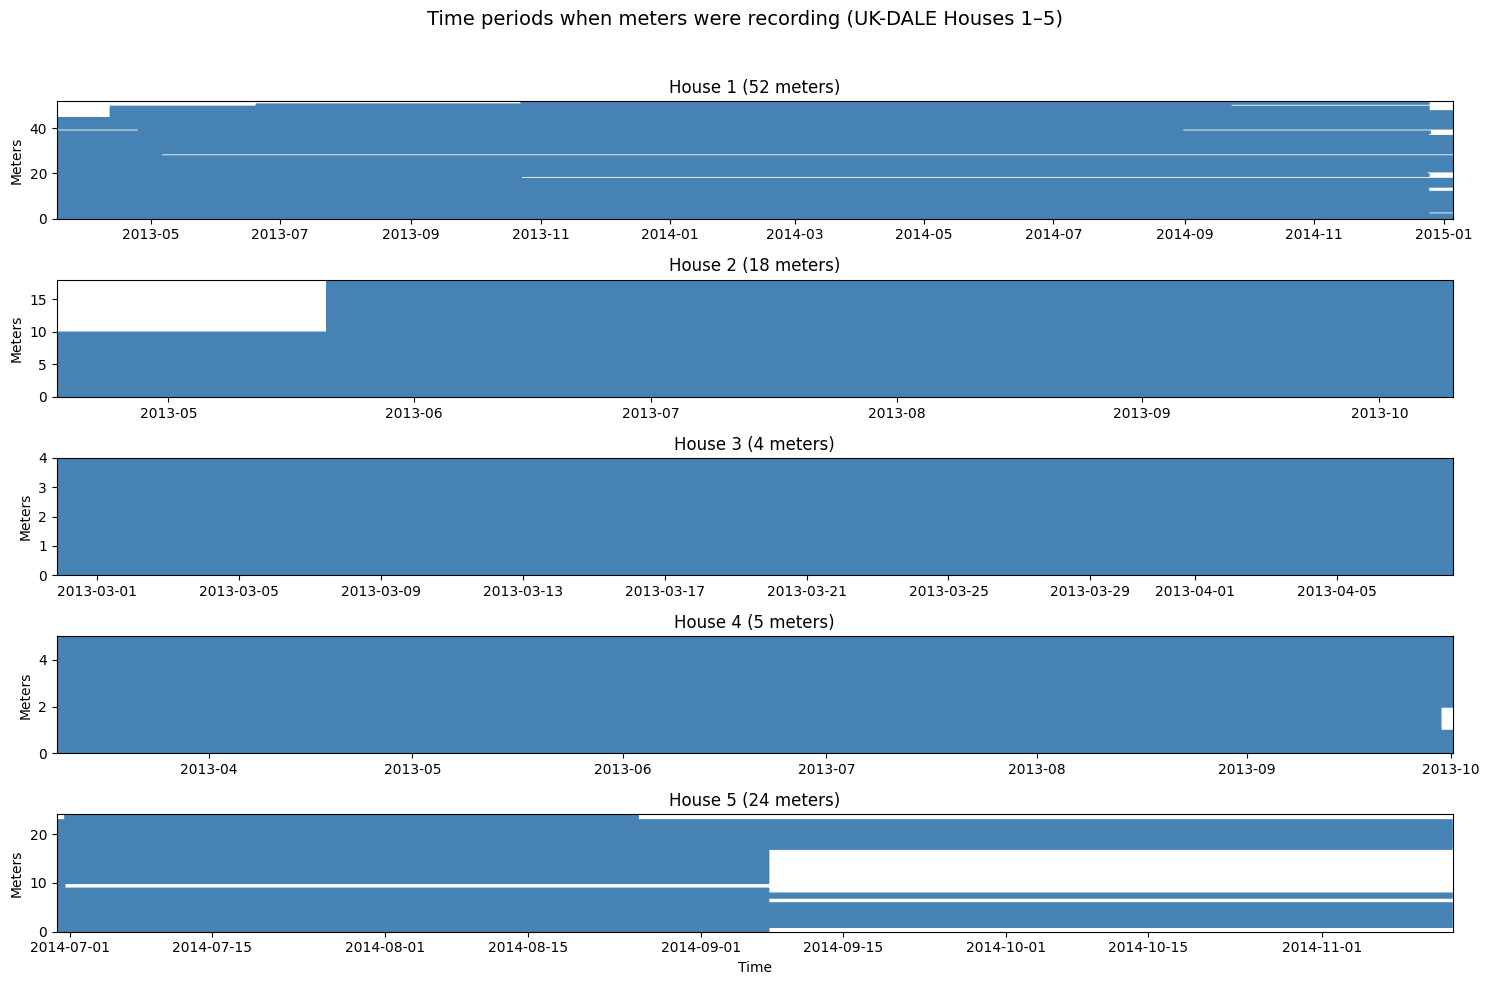

In [ ]:
import matplotlib.pyplot as plt
from nilmtk import DataSet
import pandas as pd

# Load dataset
dataset = DataSet(r"C:\Users\Raymond Tie\Desktop\NILM\datasets\ukdale.h5")

# Create subplots for the 5 houses
fig, axes = plt.subplots(5, 1, figsize=(15, 10), sharex=False)

for i in range(1, 6):
    building = dataset.buildings[i]
    elec = building.elec
    
    # Get mains for available time index
    mains = elec.mains()
    df = next(mains.load(sample_period=60))  # 1-min sampling
    df = df.dropna()
    
    if df.empty:
        axes[i-1].set_title(f"House {i} (no data)")
        continue
    
    # Extract this house's time range
    start, end = df.index.min(), df.index.max()
    
    # For each submeter, mark availability
    for j, meter in enumerate(elec.submeters().meters):
        df_meter = next(meter.load(sample_period=60))
        df_meter = df_meter.dropna()
        if df_meter.empty:
            continue
        axes[i-1].fill_between(
            df_meter.index, j, j+1,
            color="steelblue"
        )
    
    # Style
    axes[i-1].set_title(f"House {i} ({len(elec.submeters().meters)} meters)")
    axes[i-1].set_ylabel("Meters")
    axes[i-1].set_xlim(start, end)
    axes[i-1].set_ylim(0, len(elec.submeters().meters))

plt.xlabel("Time")
plt.suptitle("Time periods when meters were recording (UK-DALE Houses 1–5)", fontsize=14)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


c:\Users\Raymond Tie\Desktop\NILM\.venv\Lib\site-packages\nilmtk\utils.py:509: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")
c:\Users\Raymond Tie\Desktop\NILM\.venv\Lib\site-packages\nilmtk\utils.py:501: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  return fill_method(how(data.resample(rule, **resample_kwargs)))
c:\Users\Raymond Tie\Desktop\NILM\.venv\Lib\site-packages\nilmtk\utils.py:501: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  return fill_method(how(data.resample(rule, **resample_kwargs)))
c:\Users\Raymond Tie\Desktop\NILM\.venv\Lib\site-packages\nilmtk\utils.py:501: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  return fill_method(how(data.resample(rule, **resample_kwargs)))
c:\Users\Raymond Tie\Desktop\NILM\.venv\Lib\site-packages\nilmtk\utils.py:

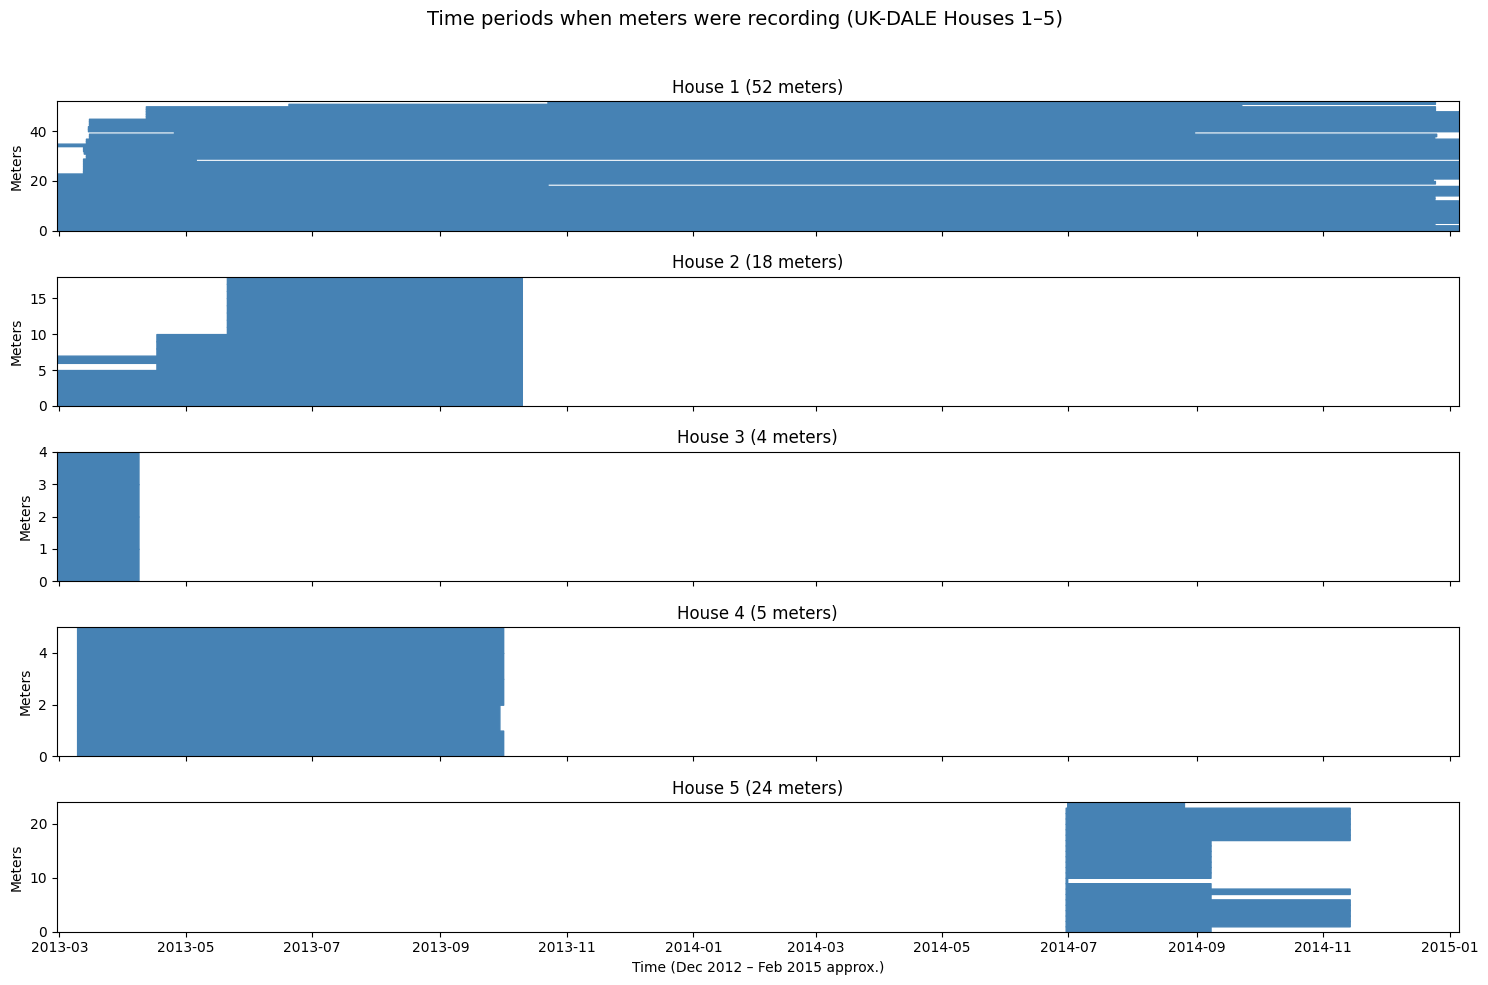

In [ ]:
import matplotlib.pyplot as plt
from nilmtk import DataSet
import pandas as pd

# Load dataset
dataset = DataSet(r"C:\Users\Raymond Tie\Desktop\NILM\datasets\ukdale.h5")

# --- Find global start and end across all buildings ---
global_starts = []
global_ends = []

for i in range(1, 6):
    building = dataset.buildings[i]
    mains = building.elec.mains()
    try:
        df = next(mains.load(sample_period=60))
        df = df.dropna()
        if not df.empty:
            global_starts.append(df.index.min())
            global_ends.append(df.index.max())
    except:
        continue

global_start = min(global_starts)
global_end = max(global_ends)

# --- Create subplots ---
fig, axes = plt.subplots(5, 1, figsize=(15, 10), sharex=True)

for i in range(1, 6):
    building = dataset.buildings[i]
    elec = building.elec
    
    mains = elec.mains()
    try:
        df = next(mains.load(sample_period=60))
        df = df.dropna()
    except:
        df = pd.DataFrame()
    
    if df.empty:
        axes[i-1].set_title(f"House {i} (no data)")
        axes[i-1].set_xlim(global_start, global_end)
        continue
    
    # For each submeter, mark availability
    for j, meter in enumerate(elec.submeters().meters):
        try:
            df_meter = next(meter.load(sample_period=60))
            df_meter = df_meter.dropna()
            if df_meter.empty:
                continue
            axes[i-1].fill_between(
                df_meter.index, j, j+1,
                color="steelblue"
            )
        except:
            continue
    
    # Style
    axes[i-1].set_title(f"House {i} ({len(elec.submeters().meters)} meters)")
    axes[i-1].set_ylabel("Meters")
    axes[i-1].set_xlim(global_start, global_end)   # ✅ force same x-axis for all
    axes[i-1].set_ylim(0, len(elec.submeters().meters))

# X-axis shared for all
plt.xlabel("Time (Dec 2012 – Feb 2015 approx.)")
plt.suptitle("Time periods when meters were recording (UK-DALE Houses 1–5)", fontsize=14)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


c:\Users\Raymond Tie\Desktop\NILM\.venv\Lib\site-packages\nilmtk\utils.py:509: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")
c:\Users\Raymond Tie\Desktop\NILM\.venv\Lib\site-packages\nilmtk\utils.py:501: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  return fill_method(how(data.resample(rule, **resample_kwargs)))
c:\Users\Raymond Tie\Desktop\NILM\.venv\Lib\site-packages\nilmtk\utils.py:501: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  return fill_method(how(data.resample(rule, **resample_kwargs)))
c:\Users\Raymond Tie\Desktop\NILM\.venv\Lib\site-packages\nilmtk\utils.py:501: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  return fill_method(how(data.resample(rule, **resample_kwargs)))
c:\Users\Raymond Tie\Desktop\NILM\.venv\Lib\site-packages\nilmtk\utils.py:

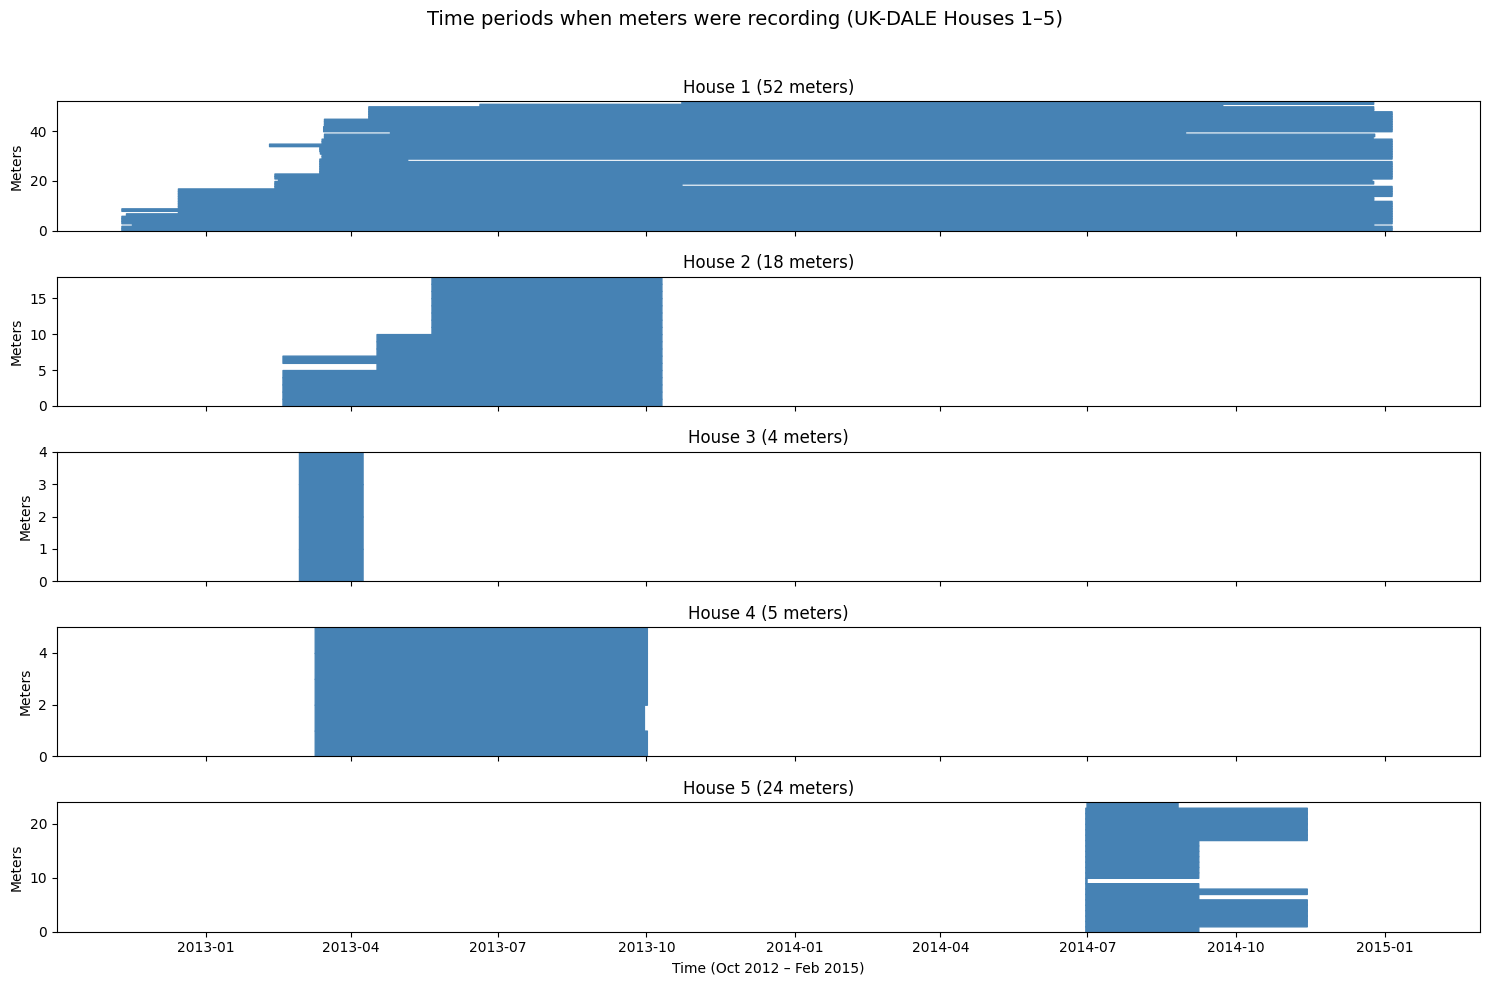

In [ ]:
import matplotlib.pyplot as plt
from nilmtk import DataSet
import pandas as pd

# Load dataset
dataset = DataSet(r"C:\Users\Raymond Tie\Desktop\NILM\datasets\ukdale.h5")

# --- Define fixed global x-axis range ---
global_start = pd.Timestamp("2012-10-01", tz="UTC")  # start October 2012
global_end = pd.Timestamp("2015-02-28 23:59:59", tz="UTC")  # end Feb 2015

# --- Create subplots ---
fig, axes = plt.subplots(5, 1, figsize=(15, 10), sharex=True)

for i in range(1, 6):
    building = dataset.buildings[i]
    elec = building.elec
    
    mains = elec.mains()
    try:
        df = next(mains.load(sample_period=60))
        df = df.dropna()
    except:
        df = pd.DataFrame()
    
    if df.empty:
        axes[i-1].set_title(f"House {i} (no data)")
        axes[i-1].set_xlim(global_start, global_end)
        axes[i-1].set_ylim(0, 1)
        continue
    
    # For each submeter, mark availability
    for j, meter in enumerate(elec.submeters().meters):
        try:
            df_meter = next(meter.load(sample_period=60))
            df_meter = df_meter.dropna()
            if df_meter.empty:
                continue
            axes[i-1].fill_between(
                df_meter.index, j, j+1,
                color="steelblue"
            )
        except:
            continue
    
    # Style
    axes[i-1].set_title(f"House {i} ({len(elec.submeters().meters)} meters)")
    axes[i-1].set_ylabel("Meters")
    axes[i-1].set_xlim(global_start, global_end)
    axes[i-1].set_ylim(0, len(elec.submeters().meters))

# Only show x-axis ticks on the last subplot
for ax in axes[:-1]:
    ax.label_outer()

axes[-1].set_xlabel("Time (Oct 2012 – Feb 2015)")

plt.suptitle("Time periods when meters were recording (UK-DALE Houses 1–5)", fontsize=14)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


c:\Users\Raymond Tie\Desktop\NILM\.venv\Lib\site-packages\nilmtk\utils.py:509: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")
c:\Users\Raymond Tie\Desktop\NILM\.venv\Lib\site-packages\nilmtk\utils.py:501: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  return fill_method(how(data.resample(rule, **resample_kwargs)))
c:\Users\Raymond Tie\Desktop\NILM\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


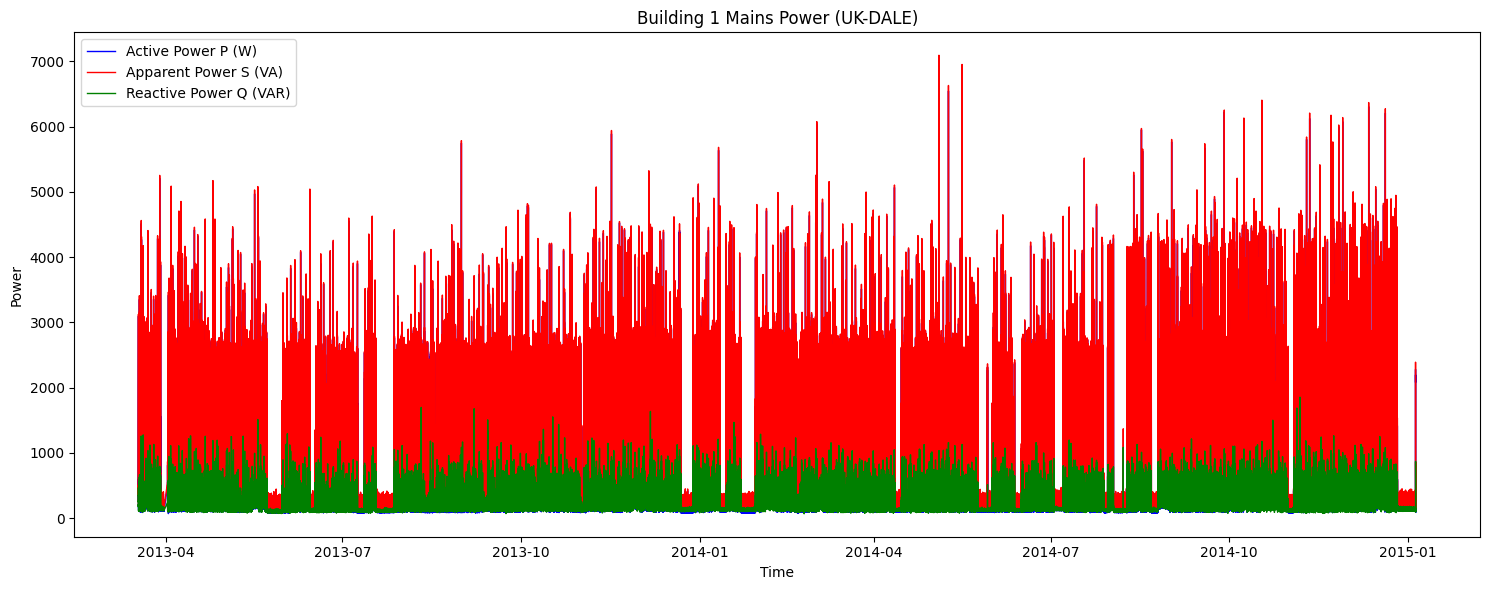

In [ ]:
import matplotlib.pyplot as plt
from nilmtk import DataSet
import pandas as pd
import numpy as np

# Load dataset
dataset = DataSet(r"C:\Users\Raymond Tie\Desktop\NILM\datasets\ukdale.h5")

# Select building 1 mains
building = dataset.buildings[1]
mains = building.elec.mains()

# Load 1 day of data (for readability, you can expand this to whole range)
df = next(mains.load(sample_period=60))  # 1-min sampling
df = df.dropna()

# Some mains contain multi-index columns, e.g. ('power', 'active') or ('power', 'apparent')
if ('power', 'active') in df.columns:
    P = df[('power', 'active')]
else:
    P = df.iloc[:,0]   # fallback

if ('power', 'apparent') in df.columns:
    S = df[('power', 'apparent')]
else:
    S = None

# Compute Q (reactive power) if S exists
if S is not None:
    Q = np.sqrt(np.clip(S**2 - P**2, 0, None))  # ensure non-negative under sqrt
else:
    Q = None

# Plot results
plt.figure(figsize=(15,6))
plt.plot(P.index, P, label="Active Power P (W)", color="blue", linewidth=1)

if S is not None:
    plt.plot(S.index, S, label="Apparent Power S (VA)", color="red", linewidth=1)
if Q is not None:
    plt.plot(Q.index, Q, label="Reactive Power Q (VAR)", color="green", linewidth=1)

plt.title("Building 1 Mains Power (UK-DALE)")
plt.ylabel("Power")
plt.xlabel("Time")
plt.legend()
plt.tight_layout()
plt.show()


Detect Activation for the Appliances


In [ ]:
from nilmtk import DataSet

# Load dataset
dataset = DataSet(r"C:\Users\Raymond Tie\Desktop\NILM\datasets\ukdale.h5")
elec = dataset.buildings[1].elec

# Pick target appliance (e.g., fridge)
fridge = elec['fridge']

activations = fridge.get_activations()
print(len(activations))


c:\Users\Raymond Tie\Desktop\NILM\.venv\Lib\site-packages\nilmtk\utils.py:501: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  return fill_method(how(data.resample(rule, **resample_kwargs)))


18872


In [ ]:
# Extract individual operating cycles ("activations") from the appliance's power signal
activations = fridge.get_activations(
    on_power_threshold=50,  # The power threshold (in Watts) that defines when the appliance is considered "ON".
                            # Any power reading above this value is part of an activation. Readings below are "OFF".
                            # This ignores the fridge's small standby power and only captures significant compressor cycles.

    min_off_duration=60,    # The minimum duration (in seconds) the appliance must be below the threshold
                            # to be considered truly "OFF". This prevents brief power dips during a single
                            # cooling cycle from being incorrectly split into multiple smaller activations.

    min_on_duration=60      # The minimum duration (in seconds) a power reading must be above the threshold
                            # to be considered a valid activation. This filters out transient noise and
                            # very short, insignificant power spikes that are not part of a complete cooling cycle.
)

print(f"Number of significant fridge activations found: {len(activations)}")

c:\Users\Raymond Tie\Desktop\NILM\.venv\Lib\site-packages\nilmtk\utils.py:501: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  return fill_method(how(data.resample(rule, **resample_kwargs)))


Number of significant fridge activations found: 18872


Try TVDR-TDWS Feature Extraction
Step 1: Find Activation Event

Step 1: Finding activation events...
Loading dataset...
Loading power data...
Detecting activation events...

Found 5 activation events:
Event 1: 2013-11-08 07:18:24+00:00
Event 2: 2013-11-08 08:05:12+00:00
Event 3: 2013-11-08 09:34:54+00:00
Event 4: 2013-11-08 09:36:30+00:00
Event 5: 2013-11-08 18:39:24+00:00


c:\Users\Raymond Tie\Desktop\NILM\.venv\Lib\site-packages\nilmtk\utils.py:501: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  return fill_method(how(data.resample(rule, **resample_kwargs)))



Plot saved as 'activation_events.png'

Step 1 completed! These T₁ values are ready for Step 2.


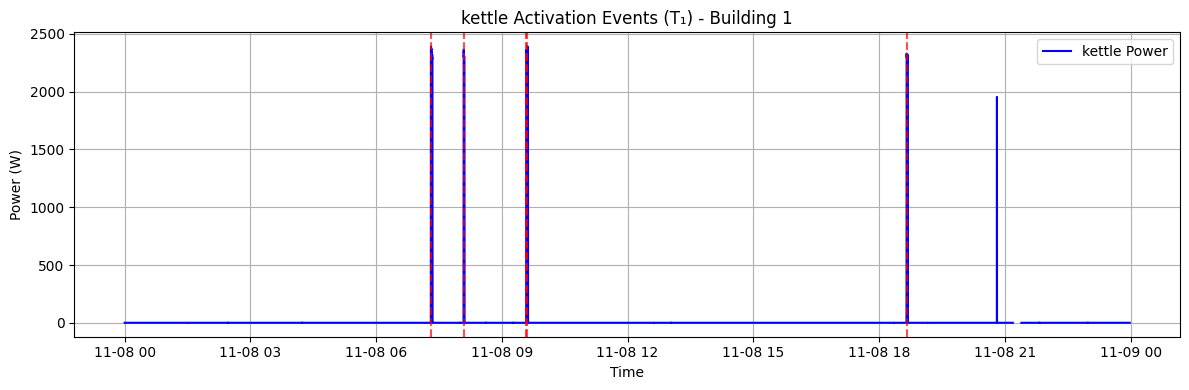

In [17]:
#!/usr/bin/env python3
"""
Simple Step 1: Find Appliance Activation Events using NILMTK
"""

import pandas as pd
import matplotlib.pyplot as plt
from nilmtk import DataSet
from nilmtk.utils import get_datastore

# Configuration
dataset_path = r"C:\Users\Raymond Tie\Desktop\NILM\datasets\ukdale.h5"
building = 1
appliance = "kettle"
threshold_power = 2000  # Watts
start_time = "2013-11-08 00:00:00"
end_time = "2013-11-08 23:59:00"

print("Step 1: Finding activation events...")
print("=" * 50)

try:
    # Load the dataset
    print("Loading dataset...")
    dataset = DataSet(dataset_path)
    dataset.set_window(start=start_time, end=end_time)

    # Get the electrical data for the building
    elec = dataset.buildings[building].elec

    # Get the specific appliance (kettle)
    kettle_meter = elec[appliance]

    # Load the power data - FIXED: Using proper power_series method
    print("Loading power data...")
    power_series = next(kettle_meter.power_series(sample_period=6))  # 6 seconds sample period
    power_data = pd.Series(power_series, index=power_series.index)

    if power_data.empty:
        print("No power data found!")
        dataset.store.close()
        exit()

    # Find activation events
    print("Detecting activation events...")
    activations = []
    prev_power = 0
    activation_times = []

    for timestamp, power in power_data.items():
        if power > threshold_power and prev_power <= threshold_power:
            # This is an activation event
            activation_times.append(timestamp)
        prev_power = power

    print(f"\nFound {len(activation_times)} activation events:")
    for i, time in enumerate(activation_times, 1):
        print(f"Event {i}: {time}")

    # Create a simple plot
    plt.figure(figsize=(12, 4))
    plt.plot(power_data.index, power_data.values, 'b-', label=f'{appliance} Power')

    # Mark each activation event
    for time in activation_times:
        plt.axvline(x=time, color='red', linestyle='--', alpha=0.7)

    plt.title(f'{appliance} Activation Events (T₁) - Building {building}')
    plt.xlabel('Time')
    plt.ylabel('Power (W)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save the plot
    plt.savefig('activation_events.png', dpi=150, bbox_inches='tight')
    print("\nPlot saved as 'activation_events.png'")

    print("\nStep 1 completed! These T₁ values are ready for Step 2.")

except Exception as e:
    print(f"An error occurred: {str(e)}")
    import traceback
    traceback.print_exc()

finally:
    # Ensure the dataset is always closed
    if 'dataset' in locals():
        dataset.store.close()

Step 2: Find Voltage Zero-Crossings (T₂)


TVDR-TDWS: Step 1 + Step 2 Integrated Implementation
Step 1: Detecting activation events...
Loading power data...
Detecting activation events...

Found 5 activation events:
Event 1: 2013-11-08 07:18:24+00:00
Event 2: 2013-11-08 08:05:12+00:00
Event 3: 2013-11-08 09:34:54+00:00
Event 4: 2013-11-08 09:36:30+00:00
Event 5: 2013-11-08 18:39:24+00:00


c:\Users\Raymond Tie\Desktop\NILM\.venv\Lib\site-packages\nilmtk\utils.py:501: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  return fill_method(how(data.resample(rule, **resample_kwargs)))


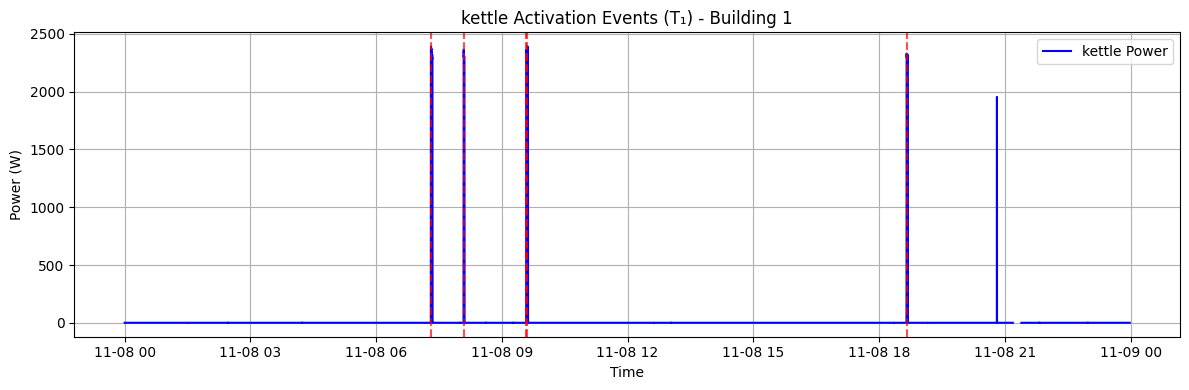

Displaying activation events visualization

Step 2: Detecting voltage zero-crossings...
Loading voltage data...
Voltage data not available, simulating 50Hz signal...
Found 4415 voltage zero-crossings

Matched 5 activation events with zero-crossings:
Event 1: T₁=2013-11-08 07:18:24+00:00, T₂=2013-11-08 07:18:36+00:00, Δt=12.0000s
Event 2: T₁=2013-11-08 08:05:12+00:00, T₂=2013-11-08 08:05:42+00:00, Δt=30.0000s
Event 3: T₁=2013-11-08 09:34:54+00:00, T₂=2013-11-08 09:35:30+00:00, Δt=36.0000s
Event 4: T₁=2013-11-08 09:36:30+00:00, T₂=2013-11-08 09:36:48+00:00, Δt=18.0000s
Event 5: T₁=2013-11-08 18:39:24+00:00, T₂=2013-11-08 18:39:30+00:00, Δt=6.0000s


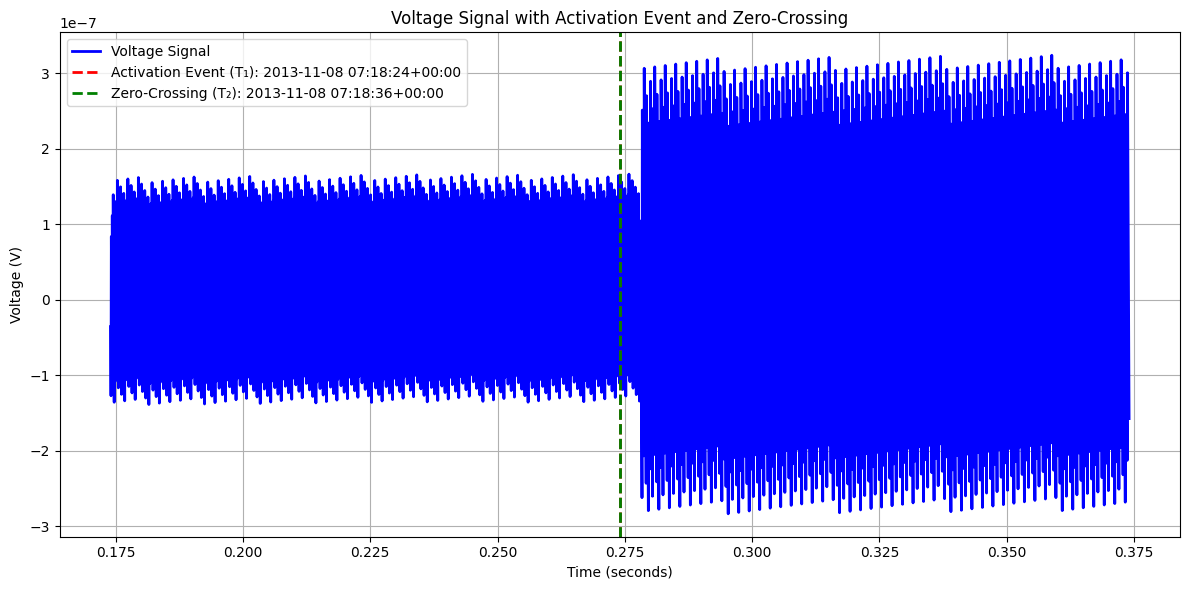

Displaying voltage zero-crossing visualization
Results saved to 'results/tvdr_tdws_results.csv'

TVDR-TDWS Step 1 + Step 2 completed successfully!
Activation events (T₁) and zero-crossings (T₂) are ready for further analysis


In [41]:
#!/usr/bin/env python3
"""
TVDR-TDWS Complete Implementation: Step 1 + Step 2
Integrated appliance activation detection and voltage zero-crossing detection
With interactive visualizations
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nilmtk import DataSet
import os
import traceback

# Configuration
dataset_path = r"C:\Users\Raymond Tie\Desktop\NILM\datasets\ukdale.h5"
building = 1
appliance = "kettle"
threshold_power = 2000  # Watts
start_time = "2013-11-08 00:00:00"
end_time = "2013-11-08 23:59:00"
sampling_rate = 16000  # 16kHz for UK-DALE high-frequency data
voltage_frequency = 50  # Standard grid frequency (50Hz)
voltage_amplitude = 325  # Peak voltage (230V RMS)

def simulate_voltage_signal(time_index, voltage_freq=50, voltage_amp=325):
    """
    Correctly simulate 50Hz voltage signal
    """
    # Convert timestamps to seconds since first timestamp
    time_seconds = (time_index - time_index[0]).total_seconds()
    
    # Generate proper 50Hz sine wave
    voltage_values = voltage_amp * np.sin(2 * np.pi * voltage_freq * time_seconds)
    
    return pd.Series(voltage_values, index=time_index)

def find_voltage_zero_crossings(voltage_signal):
    """
    Find all negative-to-positive zero-crossings in voltage signal
    """
    zero_crossings = np.where((voltage_signal[:-1] < 0) & (voltage_signal[1:] >= 0))[0]
    return zero_crossings

def find_nearest_zero_crossing(zero_crossings, event_index):
    """
    Find the nearest zero-crossing after an event
    """
    post_event_zc = zero_crossings[zero_crossings > event_index]
    return post_event_zc[0] if len(post_event_zc) > 0 else zero_crossings[-1]

def ensure_timezone_consistency(timestamp, reference_index):
    """
    Ensure timestamp timezone consistency
    """
    if timestamp.tzinfo is None and reference_index.tz is not None:
        return timestamp.tz_localize(reference_index.tz)
    elif timestamp.tzinfo is not None and reference_index.tz is None:
        return timestamp.tz_localize(None)
    return timestamp

def main():
    print("TVDR-TDWS: Step 1 + Step 2 Integrated Implementation")
    print("=" * 60)
    
    try:
        # ========================
        # Step 1: Detect Appliance Activation Events (T₁)
        # ========================
        print("Step 1: Detecting activation events...")
        
        # Load dataset
        dataset = DataSet(dataset_path)
        dataset.set_window(start=start_time, end=end_time)
        
        # Get electrical data
        elec = dataset.buildings[building].elec
        kettle_meter = elec[appliance]
        
        # Load power data
        print("Loading power data...")
        power_series = next(kettle_meter.power_series(sample_period=6))
        power_data = pd.Series(power_series, index=power_series.index)  # 修复了这行代码
        
        if power_data.empty:
            print("No power data found!")
            dataset.store.close()
            return
        
        # Detect activation events
        print("Detecting activation events...")
        activation_times = []
        prev_power = 0
        
        for timestamp, power in power_data.items():
            if power > threshold_power and prev_power <= threshold_power:
                activation_times.append(timestamp)
            prev_power = power
        
        print(f"\nFound {len(activation_times)} activation events:")
        for i, time in enumerate(activation_times, 1):
            print(f"Event {i}: {time}")
        
        # Create Step 1 visualization
        plt.figure(figsize=(12, 4))
        plt.plot(power_data.index, power_data.values, 'b-', label=f'{appliance} Power')
        
        for time in activation_times:
            plt.axvline(x=time, color='red', linestyle='--', alpha=0.7)
        
        plt.title(f'{appliance} Activation Events (T₁) - Building {building}')
        plt.xlabel('Time')
        plt.ylabel('Power (W)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        print("Displaying activation events visualization")
        
        # ========================
        # Step 2: Detect Voltage Zero-Crossings (T₂)
        # ========================
        print("\n" + "=" * 60)
        print("Step 2: Detecting voltage zero-crossings...")
        
        # Get voltage data
        print("Loading voltage data...")
        mains = elec.mains()
        
        try:
            # Try to get real voltage data
            voltage_data = next(mains.voltage().load())
            voltage_series = pd.Series(voltage_data.values, index=voltage_data.index)
            print("Successfully loaded voltage data from dataset")
        except:
            # If voltage data not available, simulate it
            print("Voltage data not available, simulating 50Hz signal...")
            voltage_series = simulate_voltage_signal(power_data.index)
        
        voltage_signal = voltage_series.values
        
        # Find all zero-crossings
        zero_crossings = find_voltage_zero_crossings(voltage_signal)
        print(f"Found {len(zero_crossings)} voltage zero-crossings")
        
        # Ensure timezone consistency
        activation_times = [ensure_timezone_consistency(t, voltage_series.index) for t in activation_times]
        
        # Find nearest zero-crossing for each activation event
        results = []
        for i, event_time in enumerate(activation_times):
            # Find event position in voltage data
            time_diffs = np.abs((voltage_series.index - event_time).total_seconds())
            event_index = np.argmin(time_diffs)
            
            # Find nearest zero-crossing
            zc_index = find_nearest_zero_crossing(zero_crossings, event_index)
            zc_time = voltage_series.index[zc_index]
            
            # Calculate time difference
            time_diff = (zc_time - event_time).total_seconds()
            
            results.append({
                'event_number': i + 1,
                'T1_time': event_time,
                'T2_time': zc_time,
                'T1_index': event_index,
                'T2_index': zc_index,
                'time_difference': time_diff
            })
        
        print(f"\nMatched {len(results)} activation events with zero-crossings:")
        for result in results:
            print(f"Event {result['event_number']}: T₁={result['T1_time']}, T₂={result['T2_time']}, Δt={result['time_difference']:.4f}s")
        
        # Create Step 2 visualization
        if len(results) > 0:
            first_result = results[0]
            event_index = first_result['T1_index']
            zc_index = first_result['T2_index']
            
            # Create time axis in seconds
            time_axis = np.arange(len(voltage_signal)) / sampling_rate
            
            # Create window around event (±0.1 seconds)
            window_size = int(0.1 * sampling_rate)
            start_idx = max(0, min(event_index, zc_index) - window_size)
            end_idx = min(len(voltage_signal), max(event_index, zc_index) + window_size)
            
            plt.figure(figsize=(12, 6))
            plt.plot(time_axis[start_idx:end_idx], 
                     voltage_signal[start_idx:end_idx], 
                     'b-', label='Voltage Signal', linewidth=2)
            
            plt.axvline(x=time_axis[event_index], color='r', linestyle='--', 
                        linewidth=2, label=f'Activation Event (T₁): {first_result["T1_time"]}')
            
            plt.axvline(x=time_axis[zc_index], color='g', linestyle='--', 
                        linewidth=2, label=f'Zero-Crossing (T₂): {first_result["T2_time"]}')
            
            plt.title('Voltage Signal with Activation Event and Zero-Crossing')
            plt.xlabel('Time (seconds)')
            plt.ylabel('Voltage (V)')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
            print("Displaying voltage zero-crossing visualization")
        
        # Save results to file (optional)
        os.makedirs("results", exist_ok=True)
        result_df = pd.DataFrame(results)
        result_df.to_csv("results/tvdr_tdws_results.csv", index=False)
        print("Results saved to 'results/tvdr_tdws_results.csv'")
        
        print("\nTVDR-TDWS Step 1 + Step 2 completed successfully!")
        print("Activation events (T₁) and zero-crossings (T₂) are ready for further analysis")
        
    except Exception as e:
        print(f"Error: {str(e)}")
        traceback.print_exc()
    finally:
        if 'dataset' in locals():
            dataset.store.close()

if __name__ == "__main__":
    main()

TVDR-TDWS Implementation with NILMTK Integration
Appliance: kettle
Sampling Rate: 16.0kHz
Voltage: 325V peak (229.8V RMS)
Window Size: 8 cycles (160ms)

Loading dataset...
Detecting activation events...
Error loading data: 'Index' object has no attribute 'abs'
Falling back to simulated data...
Using simulated data...
Generating simulated data...
Generated 160000 samples of simulated data

Generating overview of all detected events...


c:\Users\Raymond Tie\Desktop\NILM\.venv\Lib\site-packages\nilmtk\utils.py:501: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  return fill_method(how(data.resample(rule, **resample_kwargs)))
c:\Users\Raymond Tie\Desktop\NILM\.venv\Lib\site-packages\nilmtk\utils.py:501: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  return fill_method(how(data.resample(rule, **resample_kwargs)))


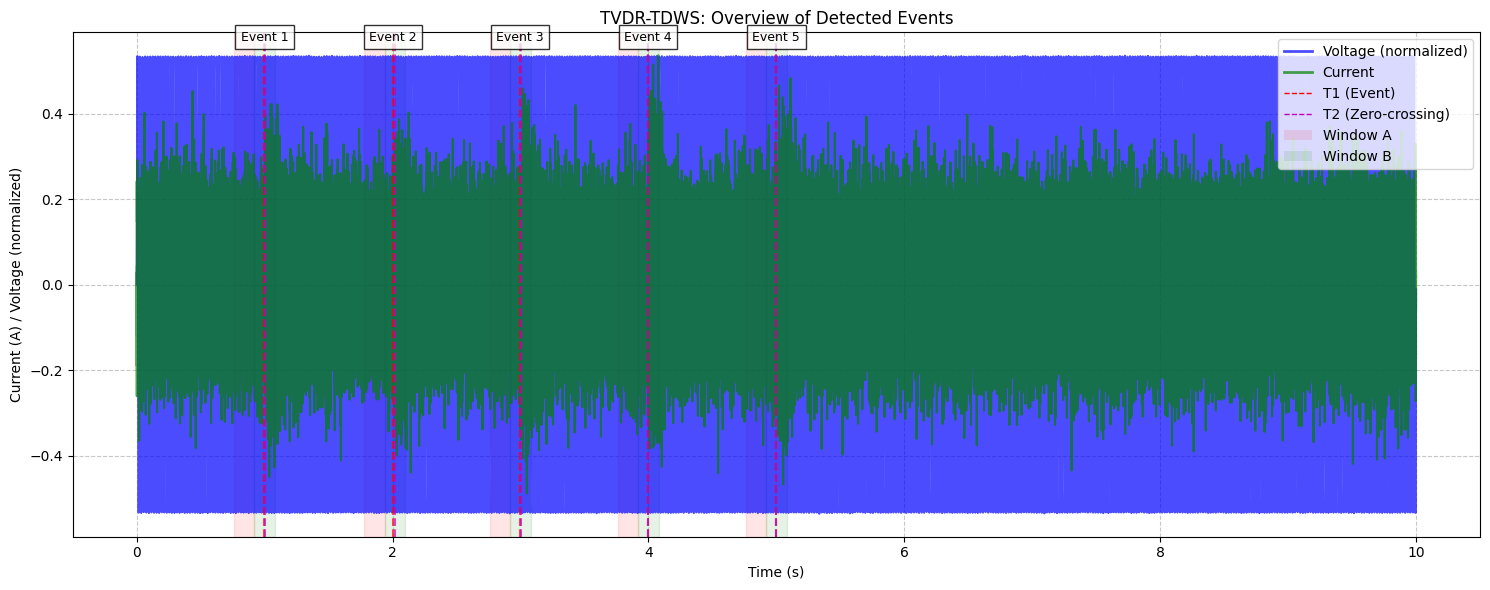


Processing 5 events...


Processing events:   0%|          | 0/5 [00:00<?, ?it/s]


Plotting event 1...


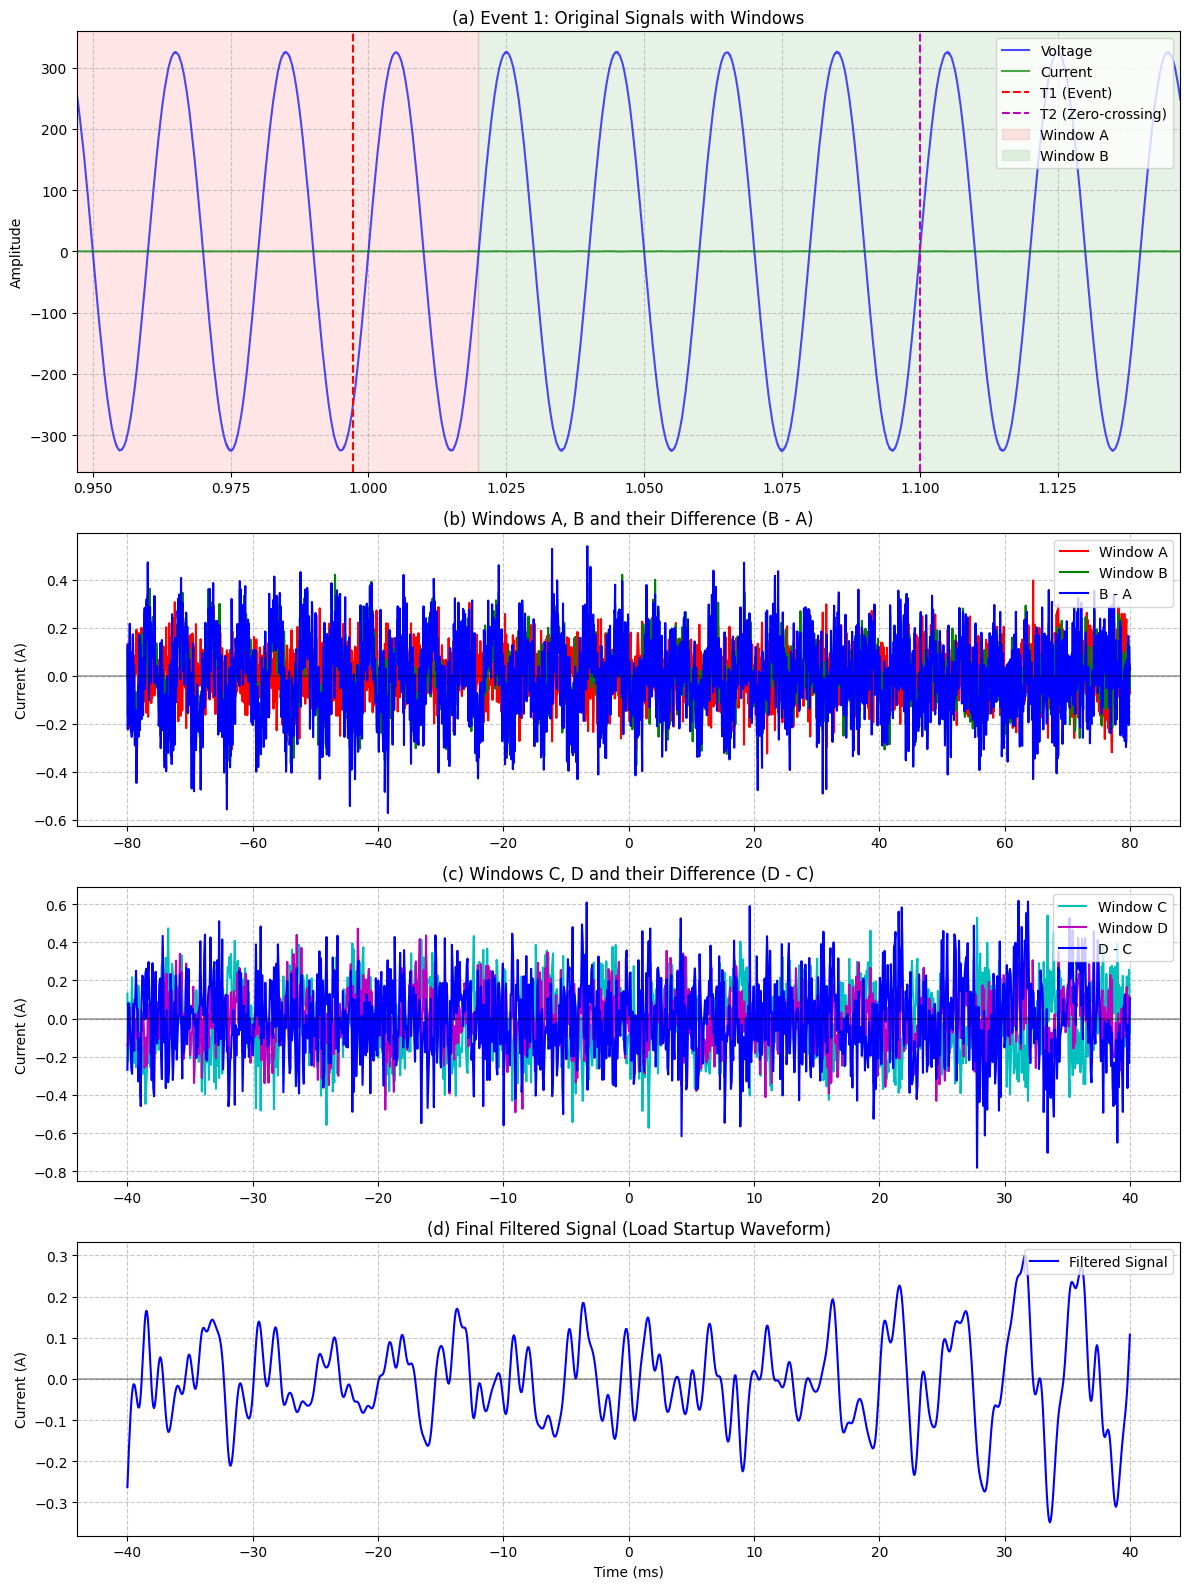

Processing events:  20%|██        | 1/5 [00:03<00:14,  3.64s/it]


Plotting event 2...


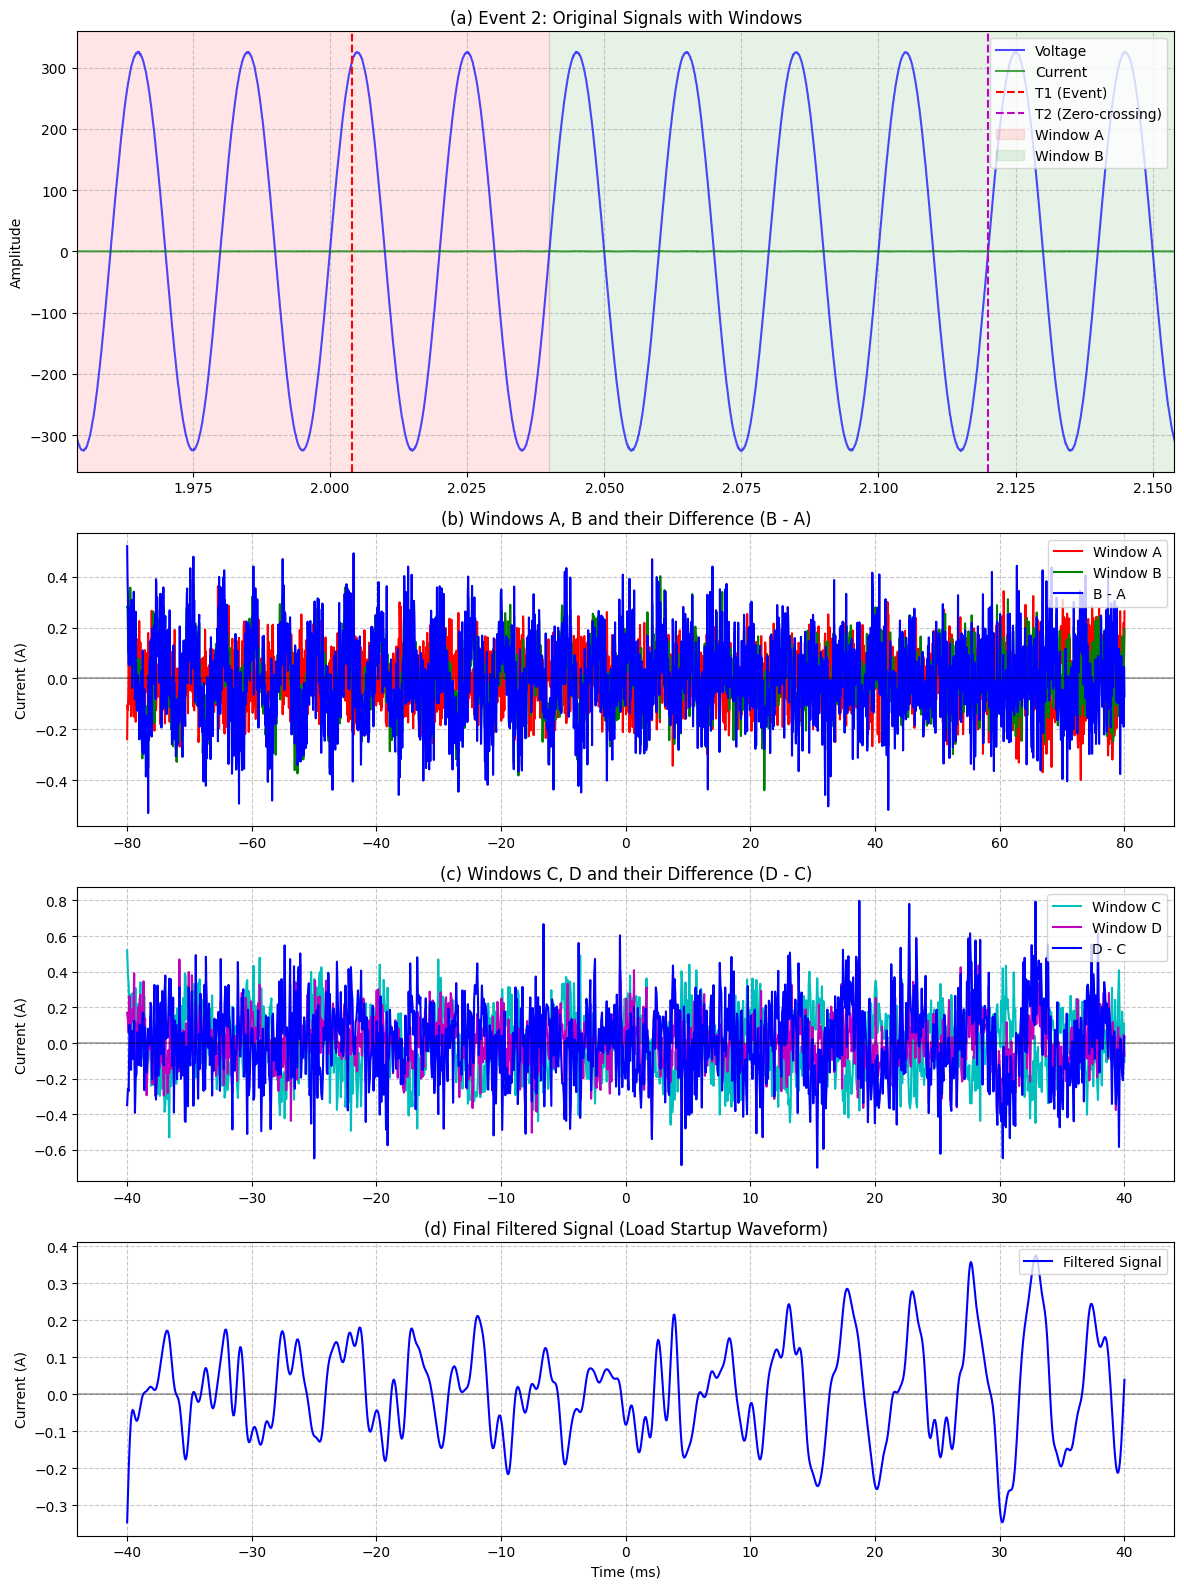

Processing events:  40%|████      | 2/5 [00:07<00:11,  3.82s/it]


Plotting event 3...


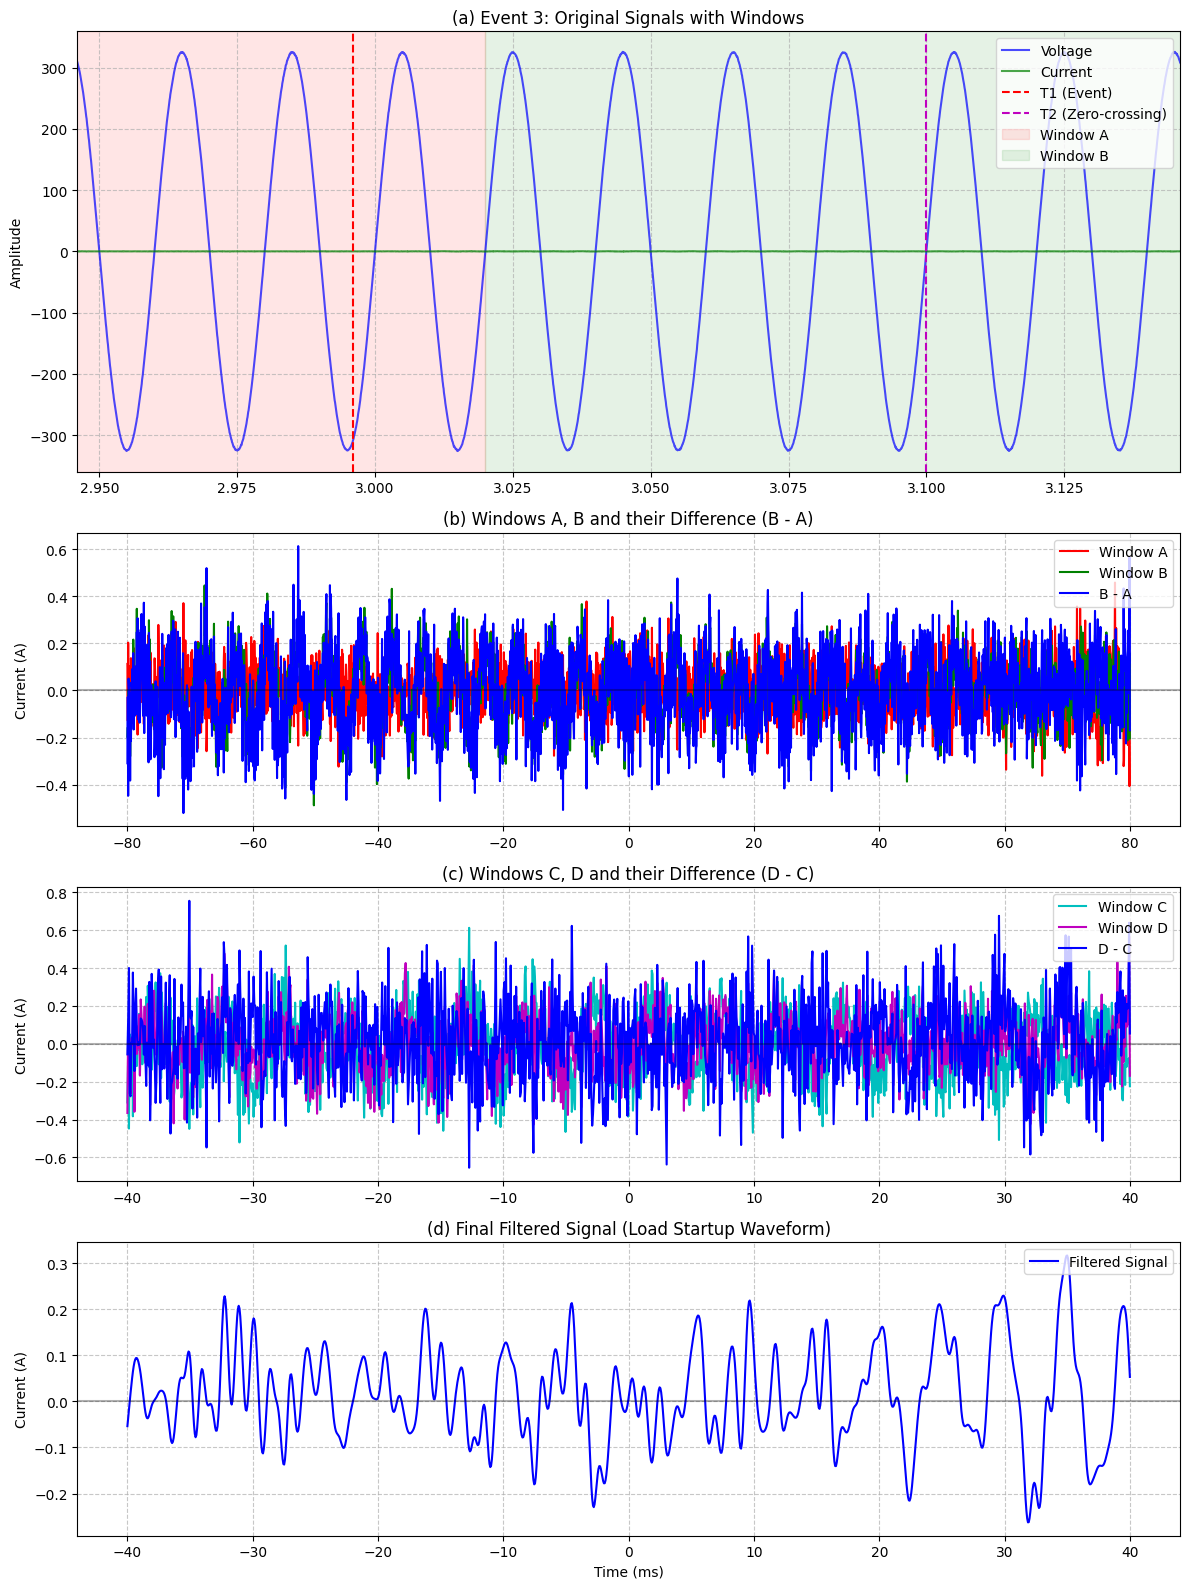

Processing events:  60%|██████    | 3/5 [00:11<00:07,  3.94s/it]


Plotting event 4...


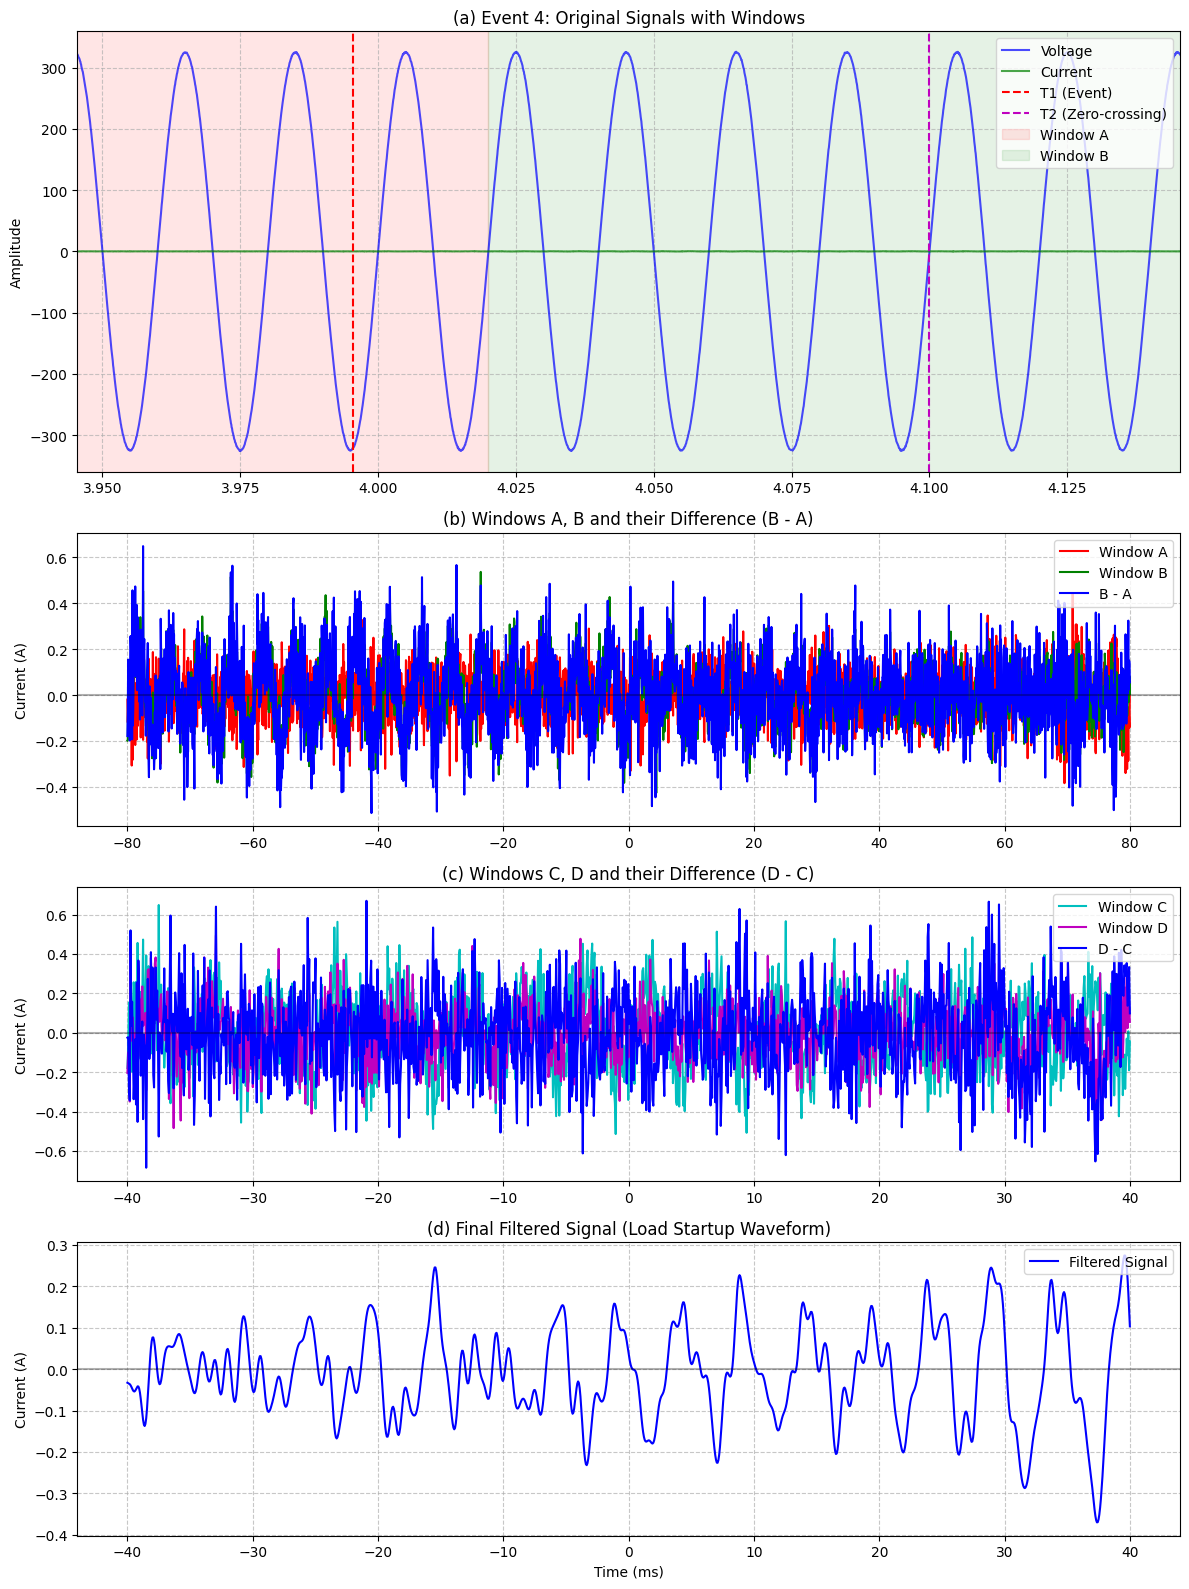

Processing events:  80%|████████  | 4/5 [00:16<00:04,  4.37s/it]


Plotting event 5...


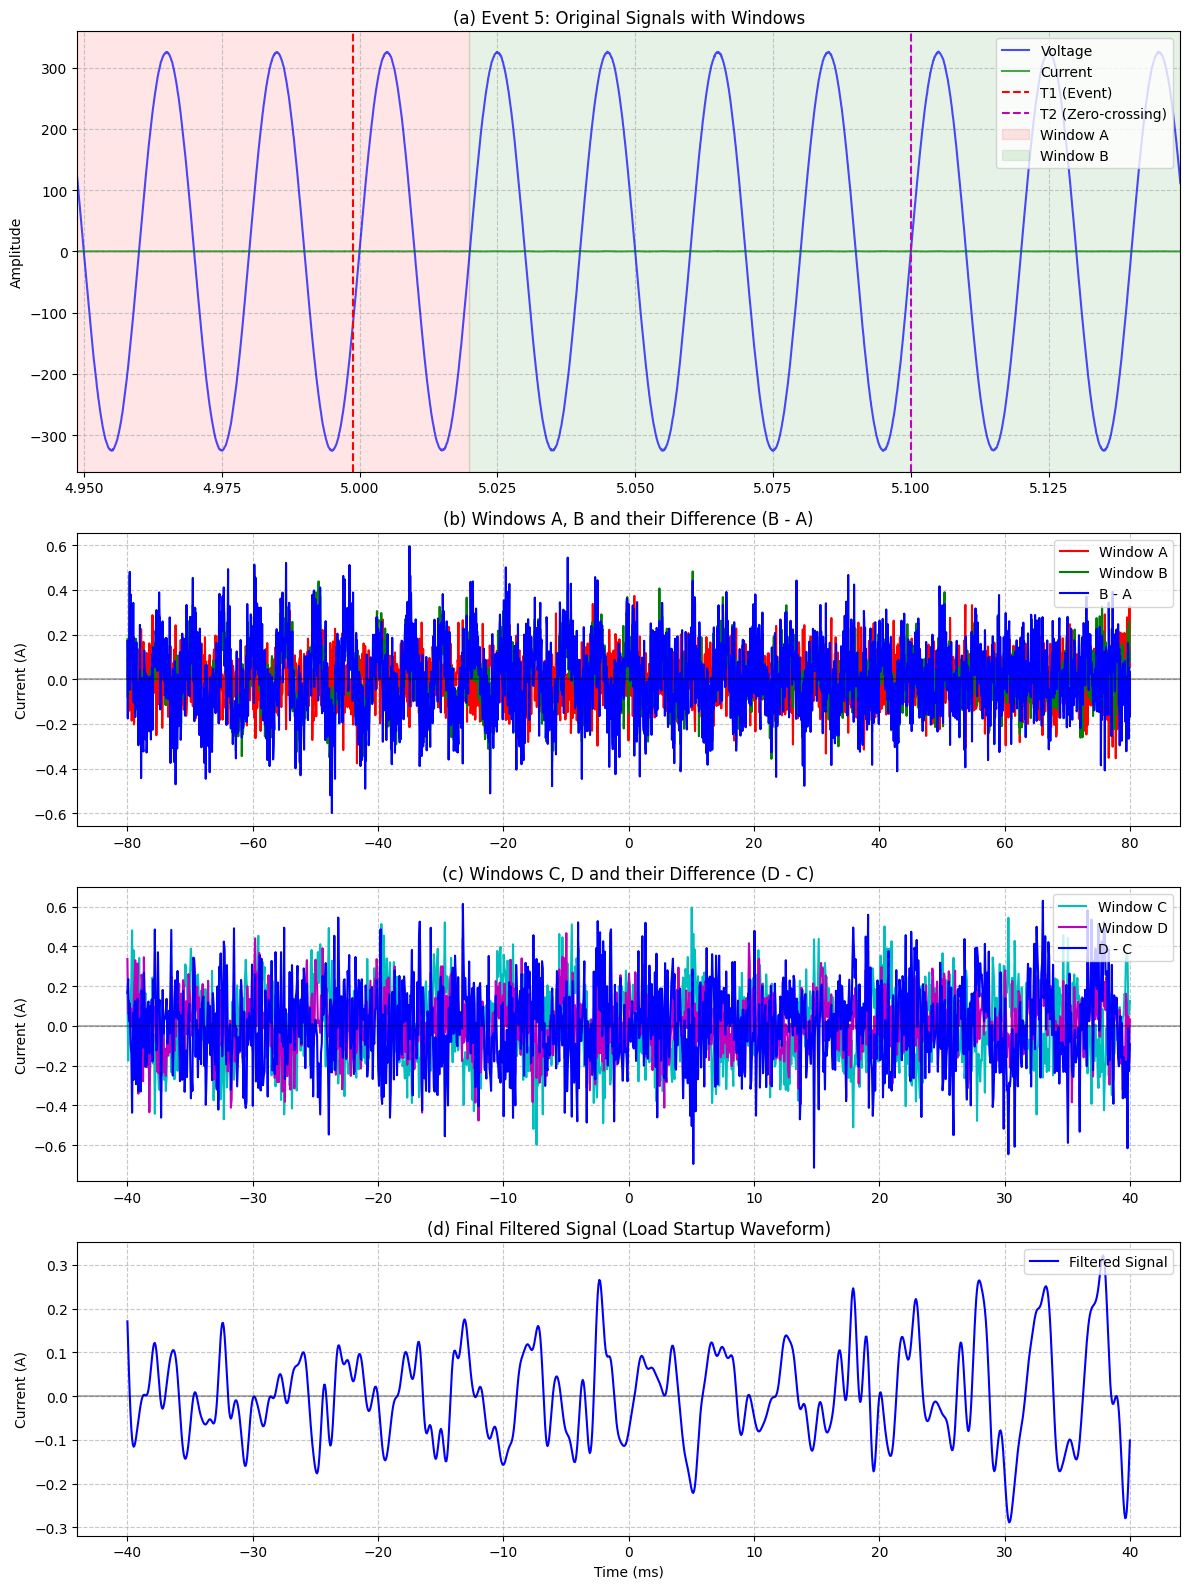

Processing events: 100%|██████████| 5/5 [00:20<00:00,  4.17s/it]


PROCESSING SUMMARY

 Event   T1 (s)   T2 (s) T2-T1 (ms) RMS A (A) RMS B (A) RMS B-A (A) RMS D-C (A) RMS Filtered (A)
     1 0.997188 1.099999     102.81    0.1021    0.1382      0.1697      0.2171           0.1083
     2 2.003938 2.119994     116.06    0.1066    0.1337      0.1682      0.2293           0.1311
     3 2.996000 3.099994     103.99    0.1030    0.1367      0.1683      0.2139           0.1024
     4 3.995437 4.099994     104.56    0.1051    0.1385      0.1701      0.2182           0.1133
     5 4.998812 5.099997     101.18    0.1020    0.1382      0.1705      0.2171           0.1067

Results saved to: results\tvdr_tdws_summary_20251005_105616.csv

TVDR-TDWS processing completed!


In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from nilmtk import DataSet
from nilmtk.utils import get_datastore
import os
from datetime import datetime
from tqdm import tqdm
from matplotlib.gridspec import GridSpec

# ===========================================
# CONFIGURATION
# ===========================================
config = {
    # Data source
    'dataset_path': r"C:\Users\Raymond Tie\Desktop\NILM\datasets\ukdale.h5",
    'building': 1,
    'appliance': "kettle",
    
    # Signal parameters (from paper)
    'sampling_rate': 16000,    # 16kHz for UK-DALE
    'voltage_freq': 50,        # 50Hz grid
    'voltage_peak': 325,       # 230V RMS → 325V peak
    'window_cycles': 8,        # 8 voltage cycles per window
    'lpf_cutoff': 1000,        # 1kHz low-pass filter
    
    # Activation detection
    'on_power_threshold': 50,  # Power threshold for activation detection (W)
    'min_off_duration': 60,    # Minimum OFF duration (s)
    'min_on_duration': 60,     # Minimum ON duration (s)
    
    # Processing
    'start_time': "2013-11-08 00:00:00",
    'end_time': "2013-11-08 23:59:00",
    'max_events': 5,           # Maximum events to process
    'simulate_data': False,    # Set to True for testing
    'output_dir': 'results'    # Directory to save results
}

# Create output directory
os.makedirs(config['output_dir'], exist_ok=True)

# ===========================================
# CORE TVDR-TDWS ALGORITHM
# ===========================================
def find_zero_crossings(voltage_signal):
    """Find all negative-to-positive zero-crossings with interpolation for precision."""
    # Find points where voltage crosses zero (negative to positive)
    crossings = np.where((voltage_signal[:-1] <= 0) & (voltage_signal[1:] > 0))[0]
    
    # Linear interpolation for more precise zero-crossing
    precise_crossings = []
    for i in crossings:
        x = [i, i+1]
        y = [voltage_signal[i], voltage_signal[i+1]]
        if y[0] != y[1]:  # Avoid division by zero
            t = np.interp(0, y, x)
            precise_crossings.append(t)
        else:
            precise_crossings.append(i + 0.5)  # If exactly equal, take midpoint
    
    return np.array(precise_crossings)

def get_window(signal_data, center_idx, window_size):
    """Extract a window of data centered around an index with bounds checking."""
    half = int(window_size // 2)
    start = max(0, int(center_idx - half))
    end = min(len(signal_data), int(center_idx + half))
    return signal_data[start:end], start, end

def process_tvdr_tdws(voltage, current, event_idx, sampling_rate, voltage_freq, window_cycles, lpf_cutoff):
    """Process a single event using TVDR-TDWS method with precise window alignment."""
    # Step 1: Event at T1 is already detected
    t1_idx = event_idx
    
    # Step 2: Find next voltage zero-crossing (T2)
    zero_crossings = find_zero_crossings(voltage)
    if len(zero_crossings) == 0:
        return None
    
    # Find first zero-crossing after event with some margin
    margin = int(0.1 * sampling_rate)  # 100ms margin
    zc_after_t1 = zero_crossings[zero_crossings > (t1_idx + margin)]
    if len(zc_after_t1) == 0:
        return None
    t2_idx = zc_after_t1[0]
    
    # Calculate window size in samples
    samples_per_cycle = int(sampling_rate / voltage_freq)
    window_size = window_cycles * samples_per_cycle
    half_window = window_size // 2
    
    # Step 3: Define Window B (centered at T2)
    window_b, b_start, b_end = get_window(current, t2_idx, window_size)
    
    # Step 4: Define Window A (N cycles before Window B)
    a_center = t2_idx - window_size
    window_a, a_start, a_end = get_window(current, a_center, window_size)
    
    # Ensure windows have exactly the same size
    min_len = min(len(window_a), len(window_b))
    if min_len < window_size // 2:  # Skip if window is too small
        return None
    
    window_a = window_a[:min_len]
    window_b = window_b[:min_len]
    
    # Step 5: First subtraction (B - A)
    diff_ba = window_b - window_a
    
    # Step 6: Subdivide into windows C and D (N/2 cycles each)
    split_point = len(diff_ba) // 2
    window_c = diff_ba[:split_point]
    window_d = diff_ba[split_point:2*split_point]
    
    # Ensure windows are of equal length
    min_len = min(len(window_c), len(window_d))
    window_c = window_c[:min_len]
    window_d = window_d[:min_len]
    
    # Step 7: Second subtraction (D - C)
    diff_dc = window_d - window_c
    
    # Step 8: Apply low-pass filter
    nyquist = 0.5 * sampling_rate
    normal_cutoff = lpf_cutoff / nyquist
    b, a = signal.butter(4, normal_cutoff, btype='low')
    filtered_signal = signal.filtfilt(b, a, diff_dc)
    
    # Create time vectors in milliseconds
    time_ms = lambda x: np.linspace(-len(x)//2, len(x)//2, len(x)) * 1000 / sampling_rate
    
    return {
        't1_idx': t1_idx,
        't2_idx': t2_idx,
        'windows': {
            'A': window_a, 'B': window_b, 
            'C': window_c, 'D': window_d,
            'diff_ba': diff_ba,
            'diff_dc': diff_dc,
            'filtered': filtered_signal
        },
        'time_vectors': {
            'ba': time_ms(diff_ba),
            'cd': time_ms(window_c),
            'filtered': time_ms(filtered_signal)
        },
        'indices': {
            'A': (a_start, a_start + len(window_a)),
            'B': (b_start, b_start + len(window_b))
        }
    }

# ===========================================
# ACTIVATION DETECTION
# ===========================================
def detect_activations(appliance, sampling_rate, **kwargs):
    """Detect activations using NILMTK's built-in method and convert to sample indices."""
    # Default parameters
    params = {
        'on_power_threshold': 50,
        'min_off_duration': 60,
        'min_on_duration': 60
    }
    params.update(kwargs)
    
    # Get power series with 6s sampling
    power_series = next(appliance.power_series(sample_period=6))
    power_data = pd.Series(power_series, index=power_series.index)
    
    # Get activations using NILMTK's method
    activations = appliance.get_activations(**params)
    
    # Convert to sample indices for high-frequency data
    activation_indices = []
    for act in activations:
        # Get the start time of the activation
        start_time = act.index[0]
        
        # Convert to sample index in high-frequency data
        time_diff = (power_data.index - start_time).total_seconds().abs()
        closest_idx = np.argmin(time_diff)
        hf_idx = int(closest_idx * (sampling_rate / 6))  # Convert from 6s to high-freq
        
        activation_indices.append(hf_idx)
    
    return activation_indices, power_data

# ===========================================
# VISUALIZATION
# ===========================================
def plot_overview(voltage, current, event_indices, sampling_rate, window_cycles=8, voltage_freq=50, save_path=None):
    """Plot overview of all events with windows."""
    plt.figure(figsize=(15, 6))
    
    # Time vector
    t = np.arange(len(voltage)) / sampling_rate
    
    # Plot signals
    plt.plot(t, voltage / np.max(np.abs(voltage)) * np.max(np.abs(current)), 
             'b-', alpha=0.7, label='Voltage (normalized)')
    plt.plot(t, current, 'g-', alpha=0.7, label='Current')
    
    # Mark events and windows
    samples_per_cycle = int(sampling_rate / voltage_freq)
    window_size = samples_per_cycle * window_cycles
    
    for i, t1_idx in enumerate(event_indices):
        # Find next zero-crossing
        zero_crossings = find_zero_crossings(voltage)
        zc_after_t1 = zero_crossings[zero_crossings > t1_idx]
        if len(zc_after_t1) == 0:
            continue
        t2_idx = zc_after_t1[0]
        
        # Calculate window positions
        half_window = window_size // 2
        b_start = max(0, int(t2_idx - half_window))
        b_end = min(len(current), int(t2_idx + half_window))
        
        a_center = t2_idx - window_size
        a_start = max(0, int(a_center - half_window))
        a_end = min(len(current), int(a_center + half_window))
        
        # Mark T1 and T2
        plt.axvline(t1_idx/sampling_rate, color='r', linestyle='--', alpha=0.7)
        plt.axvline(t2_idx/sampling_rate, color='m', linestyle='--', alpha=0.7)
        
        # Shade windows
        plt.axvspan(a_start/sampling_rate, a_end/sampling_rate, 
                   color='red', alpha=0.1, label='_nolegend_')
        plt.axvspan(b_start/sampling_rate, b_end/sampling_rate, 
                   color='green', alpha=0.1, label='_nolegend_')
        
        # Add event number
        plt.text(t1_idx/sampling_rate, np.max(current)*1.05, f'Event {i+1}',
                ha='center', va='bottom', fontsize=9, 
                bbox=dict(facecolor='white', alpha=0.8))
    
    # Formatting
    plt.xlabel('Time (s)')
    plt.ylabel('Current (A) / Voltage (normalized)')
    plt.title('TVDR-TDWS: Overview of Detected Events')
    
    # Legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='b', alpha=0.7, lw=2, label='Voltage (normalized)'),
        Line2D([0], [0], color='g', alpha=0.7, lw=2, label='Current'),
        Line2D([0], [0], color='r', linestyle='--', lw=1, label='T1 (Event)'),
        Line2D([0], [0], color='m', linestyle='--', lw=1, label='T2 (Zero-crossing)'),
        plt.Rectangle((0,0), 1, 1, fc='red', alpha=0.1, ec='none', label='Window A'),
        plt.Rectangle((0,0), 1, 1, fc='green', alpha=0.1, ec='none', label='Window B')
    ]
    
    plt.legend(handles=legend_elements, loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_processing_steps(voltage, current, result, event_num=1, save_path=None):
    """Plot detailed processing steps for a single event."""
    fig = plt.figure(figsize=(12, 16))
    gs = GridSpec(4, 1, height_ratios=[1.5, 1, 1, 1])
    
    # Time vectors
    fs = config['sampling_rate']
    t_full = np.arange(len(voltage)) / fs
    t1 = result['t1_idx'] / fs
    t2 = result['t2_idx'] / fs
    
    # Plot 1: Original signals with windows
    ax1 = fig.add_subplot(gs[0])
    ax1.plot(t_full, voltage, 'b-', alpha=0.7, label='Voltage')
    ax1.plot(t_full, current, 'g-', alpha=0.7, label='Current')
    ax1.axvline(t1, color='r', linestyle='--', label='T1 (Event)')
    ax1.axvline(t2, color='m', linestyle='--', label='T2 (Zero-crossing)')
    
    # Shade windows A and B
    a_start, a_end = result['indices']['A']
    b_start, b_end = result['indices']['B']
    ax1.axvspan(a_start/fs, a_end/fs, color='red', alpha=0.1, label='Window A')
    ax1.axvspan(b_start/fs, b_end/fs, color='green', alpha=0.1, label='Window B')
    
    # Formatting
    ax1.set_xlim(t1 - 0.05, t1 + 0.15)  # 200ms window
    ax1.set_ylabel('Amplitude')
    ax1.set_title(f'(a) Event {event_num}: Original Signals with Windows')
    ax1.legend(loc='upper right')
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Plot 2: Windows A, B and B-A
    ax2 = fig.add_subplot(gs[1])
    ax2.plot(result['time_vectors']['ba'], result['windows']['A'], 'r-', label='Window A')
    ax2.plot(result['time_vectors']['ba'], result['windows']['B'], 'g-', label='Window B')
    ax2.plot(result['time_vectors']['ba'], result['windows']['diff_ba'], 'b-', 
             label='B - A', linewidth=1.5)
    ax2.axhline(0, color='k', linestyle='-', alpha=0.3)
    ax2.set_ylabel('Current (A)')
    ax2.set_title('(b) Windows A, B and their Difference (B - A)')
    ax2.legend(loc='upper right')
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    # Plot 3: Windows C, D and D-C
    ax3 = fig.add_subplot(gs[2])
    ax3.plot(result['time_vectors']['cd'], result['windows']['C'], 'c-', label='Window C')
    ax3.plot(result['time_vectors']['cd'], result['windows']['D'], 'm-', label='Window D')
    ax3.plot(result['time_vectors']['cd'], result['windows']['diff_dc'], 'b-', 
             label='D - C', linewidth=1.5)
    ax3.axhline(0, color='k', linestyle='-', alpha=0.3)
    ax3.set_ylabel('Current (A)')
    ax3.set_title('(c) Windows C, D and their Difference (D - C)')
    ax3.legend(loc='upper right')
    ax3.grid(True, linestyle='--', alpha=0.7)
    
    # Plot 4: Filtered signal
    ax4 = fig.add_subplot(gs[3])
    ax4.plot(result['time_vectors']['filtered'], 
             result['windows']['filtered'], 
             'b-', label='Filtered Signal')
    ax4.axhline(0, color='k', linestyle='-', alpha=0.3)
    ax4.set_xlabel('Time (ms)')
    ax4.set_ylabel('Current (A)')
    ax4.set_title('(d) Final Filtered Signal (Load Startup Waveform)')
    ax4.legend(loc='upper right')
    ax4.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# ===========================================
# DATA LOADING AND PROCESSING
# ===========================================
def generate_simulated_data(duration=10, sampling_rate=16000, voltage_freq=50, voltage_peak=325):
    """Generate simulated voltage and current data with transients."""
    print("Generating simulated data...")
    t = np.linspace(0, duration, duration * sampling_rate, endpoint=False)
    
    # Add small random noise to make voltage more realistic
    voltage_noise = np.random.normal(0, 0.5, len(t))
    voltage = pd.Series(
        voltage_peak * np.sin(2 * np.pi * voltage_freq * t) + voltage_noise,
        index=pd.date_range(start=datetime.now(), periods=len(t), 
                           freq=f"{1000/sampling_rate}ms")
    )
    
    # Create current with noise
    current = pd.Series(
        np.random.normal(0, 0.1, len(t)),
        index=voltage.index
    )
    
    # Add activation events with random timing within the cycle
    activation_indices = []
    for i in range(1, 6):
        # Add random jitter (± up to 1/4 cycle) to event timing
        jitter = np.random.randint(-sampling_rate//(4*voltage_freq), 
                                  sampling_rate//(4*voltage_freq))
        idx = i * sampling_rate + jitter  # Add jitter to 1s intervals
        if idx < len(t):  # Ensure we don't go out of bounds
            activation_indices.append(idx)
            
            # Add a transient response
            transient_len = sampling_rate // 2  # 0.5s transient
            transient = np.linspace(0, 5, transient_len) * np.exp(-np.linspace(0, 10, transient_len))
            transient *= np.sin(2 * np.pi * 100 * np.linspace(0, 1, transient_len))
            
            end = min(len(current), idx + transient_len)
            current.iloc[idx:end] += transient[:end-idx]
    
    # Create dummy power data for compatibility
    power_data = pd.Series(0, index=voltage.index[::sampling_rate//10])  # 10Hz power sampling
    for idx in activation_indices:
        power_idx = idx // (sampling_rate//10)
        if power_idx < len(power_data):
            power_data.iloc[power_idx] = 2200  # 2.2kW during activation
    
    print(f"Generated {len(voltage)} samples of simulated data")
    return voltage, current, power_data, activation_indices

# ===========================================
# MAIN EXECUTION
# ===========================================
def main():
    print("TVDR-TDWS Implementation with NILMTK Integration")
    print("=" * 70)
    print(f"Appliance: {config['appliance']}")
    print(f"Sampling Rate: {config['sampling_rate']/1000}kHz")
    print(f"Voltage: {config['voltage_peak']}V peak ({config['voltage_peak']/np.sqrt(2):.1f}V RMS)")
    print(f"Window Size: {config['window_cycles']} cycles ({config['window_cycles']/config['voltage_freq']*1000:.0f}ms)")
    print("=" * 70)
    
    # Load or generate data
    if not config['simulate_data']:
        try:
            print("\nLoading dataset...")
            dataset = DataSet(config['dataset_path'])
            dataset.set_window(start=config['start_time'], end=config['end_time'])
            elec = dataset.buildings[config['building']].elec
            appliance = elec[config['appliance']]
            
            # Detect activations using NILMTK's method
            print("Detecting activation events...")
            activation_indices, power_data = detect_activations(
                appliance,
                sampling_rate=config['sampling_rate'],
                on_power_threshold=config['on_power_threshold'],
                min_off_duration=config['min_off_duration'],
                min_on_duration=config['min_on_duration']
            )
            
            # Load high-frequency data
            print("Loading high-frequency data...")
            voltage_data = next(elec.mains().voltage().load(sample_period=1/config['sampling_rate']))
            voltage = pd.Series(voltage_data.values.flatten(), index=voltage_data.index)
            
            current_data = next(elec.mains().current().load(sample_period=1/config['sampling_rate']))
            current = pd.Series(current_data.values.flatten(), index=current_data.index)
            
        except Exception as e:
            print(f"Error loading data: {e}")
            print("Falling back to simulated data...")
            config['simulate_data'] = True
    
    if config['simulate_data']:
        print("Using simulated data...")
        voltage, current, power_data, activation_indices = generate_simulated_data(
            duration=10,
            sampling_rate=config['sampling_rate'],
            voltage_freq=config['voltage_freq'],
            voltage_peak=config['voltage_peak']
        )
    
    # Convert to numpy arrays for processing
    voltage_values = voltage.values
    current_values = current.values
    
    # Limit number of events to process
    max_events = min(len(activation_indices), config['max_events'])
    activation_indices = activation_indices[:max_events]
    
    if not activation_indices:
        print("No activation events found. Please check your parameters.")
        return
    
    # Show overview of all events
    print("\nGenerating overview of all detected events...")
    plot_overview(
        voltage_values, current_values,
        activation_indices,
        config['sampling_rate'],
        config['window_cycles'],
        config['voltage_freq'],
        save_path=os.path.join(config['output_dir'], 'overview_plot.png')
    )
    
    # Process each event
    print(f"\nProcessing {len(activation_indices)} events...")
    processed_events = []
    
    for i, idx in enumerate(tqdm(activation_indices, desc="Processing events")):
        # Ensure we have enough data after the event
        if idx + 2 * config['sampling_rate'] > len(voltage_values):
            print(f"\nNot enough data after event {i+1}, skipping...")
            continue
            
        # Process using TVDR-TDWS
        result = process_tvdr_tdws(
            voltage_values, current_values, idx,
            config['sampling_rate'],
            config['voltage_freq'],
            config['window_cycles'],
            config['lpf_cutoff']
        )
        
        if result:
            processed_events.append(result)
            print(f"\nPlotting event {i+1}...")
            plot_processing_steps(
                voltage_values, current_values, result, i+1,
                save_path=os.path.join(config['output_dir'], f'event_{i+1}_processing.png')
            )
    
    # Generate summary
    if processed_events:
        print("\n" + "="*100)
        print("PROCESSING SUMMARY")
        print("="*100)
        
        summary = []
        for i, event in enumerate(processed_events, 1):
            t1 = event['t1_idx'] / config['sampling_rate']
            t2 = event['t2_idx'] / config['sampling_rate']
            t_diff = (t2 - t1) * 1000  # in ms
            
            # Calculate RMS values
            rms = lambda x: np.sqrt(np.mean(np.square(x)))
            
            summary.append({
                'Event': i,
                'T1 (s)': f"{t1:.6f}",
                'T2 (s)': f"{t2:.6f}",
                'T2-T1 (ms)': f"{t_diff:.2f}",
                'RMS A (A)': f"{rms(event['windows']['A']):.4f}",
                'RMS B (A)': f"{rms(event['windows']['B']):.4f}",
                'RMS B-A (A)': f"{rms(event['windows']['diff_ba']):.4f}",
                'RMS D-C (A)': f"{rms(event['windows']['diff_dc']):.4f}",
                'RMS Filtered (A)': f"{rms(event['windows']['filtered']):.4f}"
            })
        
        # Display summary
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', 120)
        summary_df = pd.DataFrame(summary)
        print("\n" + summary_df.to_string(index=False))
        
        # Save results
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        results_file = os.path.join(config['output_dir'], f'tvdr_tdws_summary_{timestamp}.csv')
        summary_df.to_csv(results_file, index=False)
        print(f"\nResults saved to: {results_file}")
    
    print("\nTVDR-TDWS processing completed!")

if __name__ == "__main__":
    main()